In [1]:
#Last Updated 20161005
#Appendix 3 for Butterworth et al. 2016 
#Tectonic environments of South American porphyry-copper magmatism through time revealed
#by spatio-temporal data mining
#Nathaniel Butterworth, Daniel Steinberg, Dietmar Müller, Simon Williams, Andrew Merdith,
#Stephen Hardy

#Use pylab to show figures
%pylab --no-import-all inline

#Import a few different tools and libraries. See Utils_coreg for more detail.
from Utils_coreg import *

#Import the tools for machine learning
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

#Import data processing tools
import pickle
import matplotlib.mlab as ml

Populating the interactive namespace from numpy and matplotlib
Imported shapefile.
Imported numpy.
Imported scipy.


/Users/nbutter/anaconda3/envs/pyforgeo/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


This notebook demonstrates how we take our data and apply machine learning (ML) algorithms to it. The notebook is split in two parts. Part I loads the data and wrangles it into an appropriate form for ML. Part II is the actual ML implementations and the results of the ML.

#PART I 
#Data Wrangling

Each ore deposit with age in the Andes set is from Bertrand et al. (2014) is reconstructed to its geographical position at the time of its metallogenisis. We then 'coregister' the kinemtics associated with each ore deposit at that time in that location. We further reconstruct the ore deposits for 20 Myr prior to metallogenisis to capture the evolution of the kinematics that may lead to ore formation. We are then left with a matrix of parameters linked to each ore deposit through time (as listed below).

###List of Variables

0 Present day longitude (degrees)

1 Present day latitude (degrees)

2 Reconstructed longitude (degrees)

3 Reconstructed latitude (degrees)


4 Age (Ma)

5 Time before mineralisation (Myr)

6 Seafloor age (Myr)


7 Segment length (km)

8 Slab length (km)

9 Distance to trench edge (km)


10 Subducting plate normal velocity (km/Myr)

11 Subducting plate parallel velocity (km/Myr)

12 Overriding plate normal velocity (km/Myr)

13 Overriding plate parallel velocity (km/Myr)

14 Convergence normal rate (km/Myr)

15 Convergence parallel rate (km/Myr)


16 Subduction polarity (degrees)

17 Subduction obliquity (degrees)

18 Distance along margin (km)

19 Subduction obliquity signed (radians)

20 Ore Deposits Binary Flag (1 or 0)

In [3]:
#Load in the datasets

#Load in the dataset of porphyries coregistered with kinematics
andeanIN=open(r'../data/data_coregistered_bertrand2014.pkl','rb')
d3=pickle.load(andeanIN, encoding='bytes')
andeanIN.close()

#Load in the dataset of present day trench location coregistered with kinematics
andeanIN=open(r'../data/data_coregistered_andes.pkl','rb')
andesPresent2=pickle.load(andeanIN, encoding='bytes')
andeanIN.close()

#These data are developed by running convergence.py on GPlates datasets and the coregLoop
#function in Utils_coreg.py

/Users/nbutter/anaconda3/envs/pyforgeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Users/nbutter/anaconda3/envs/pyforgeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/nbutter/anaconda3/envs/pyforgeo/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


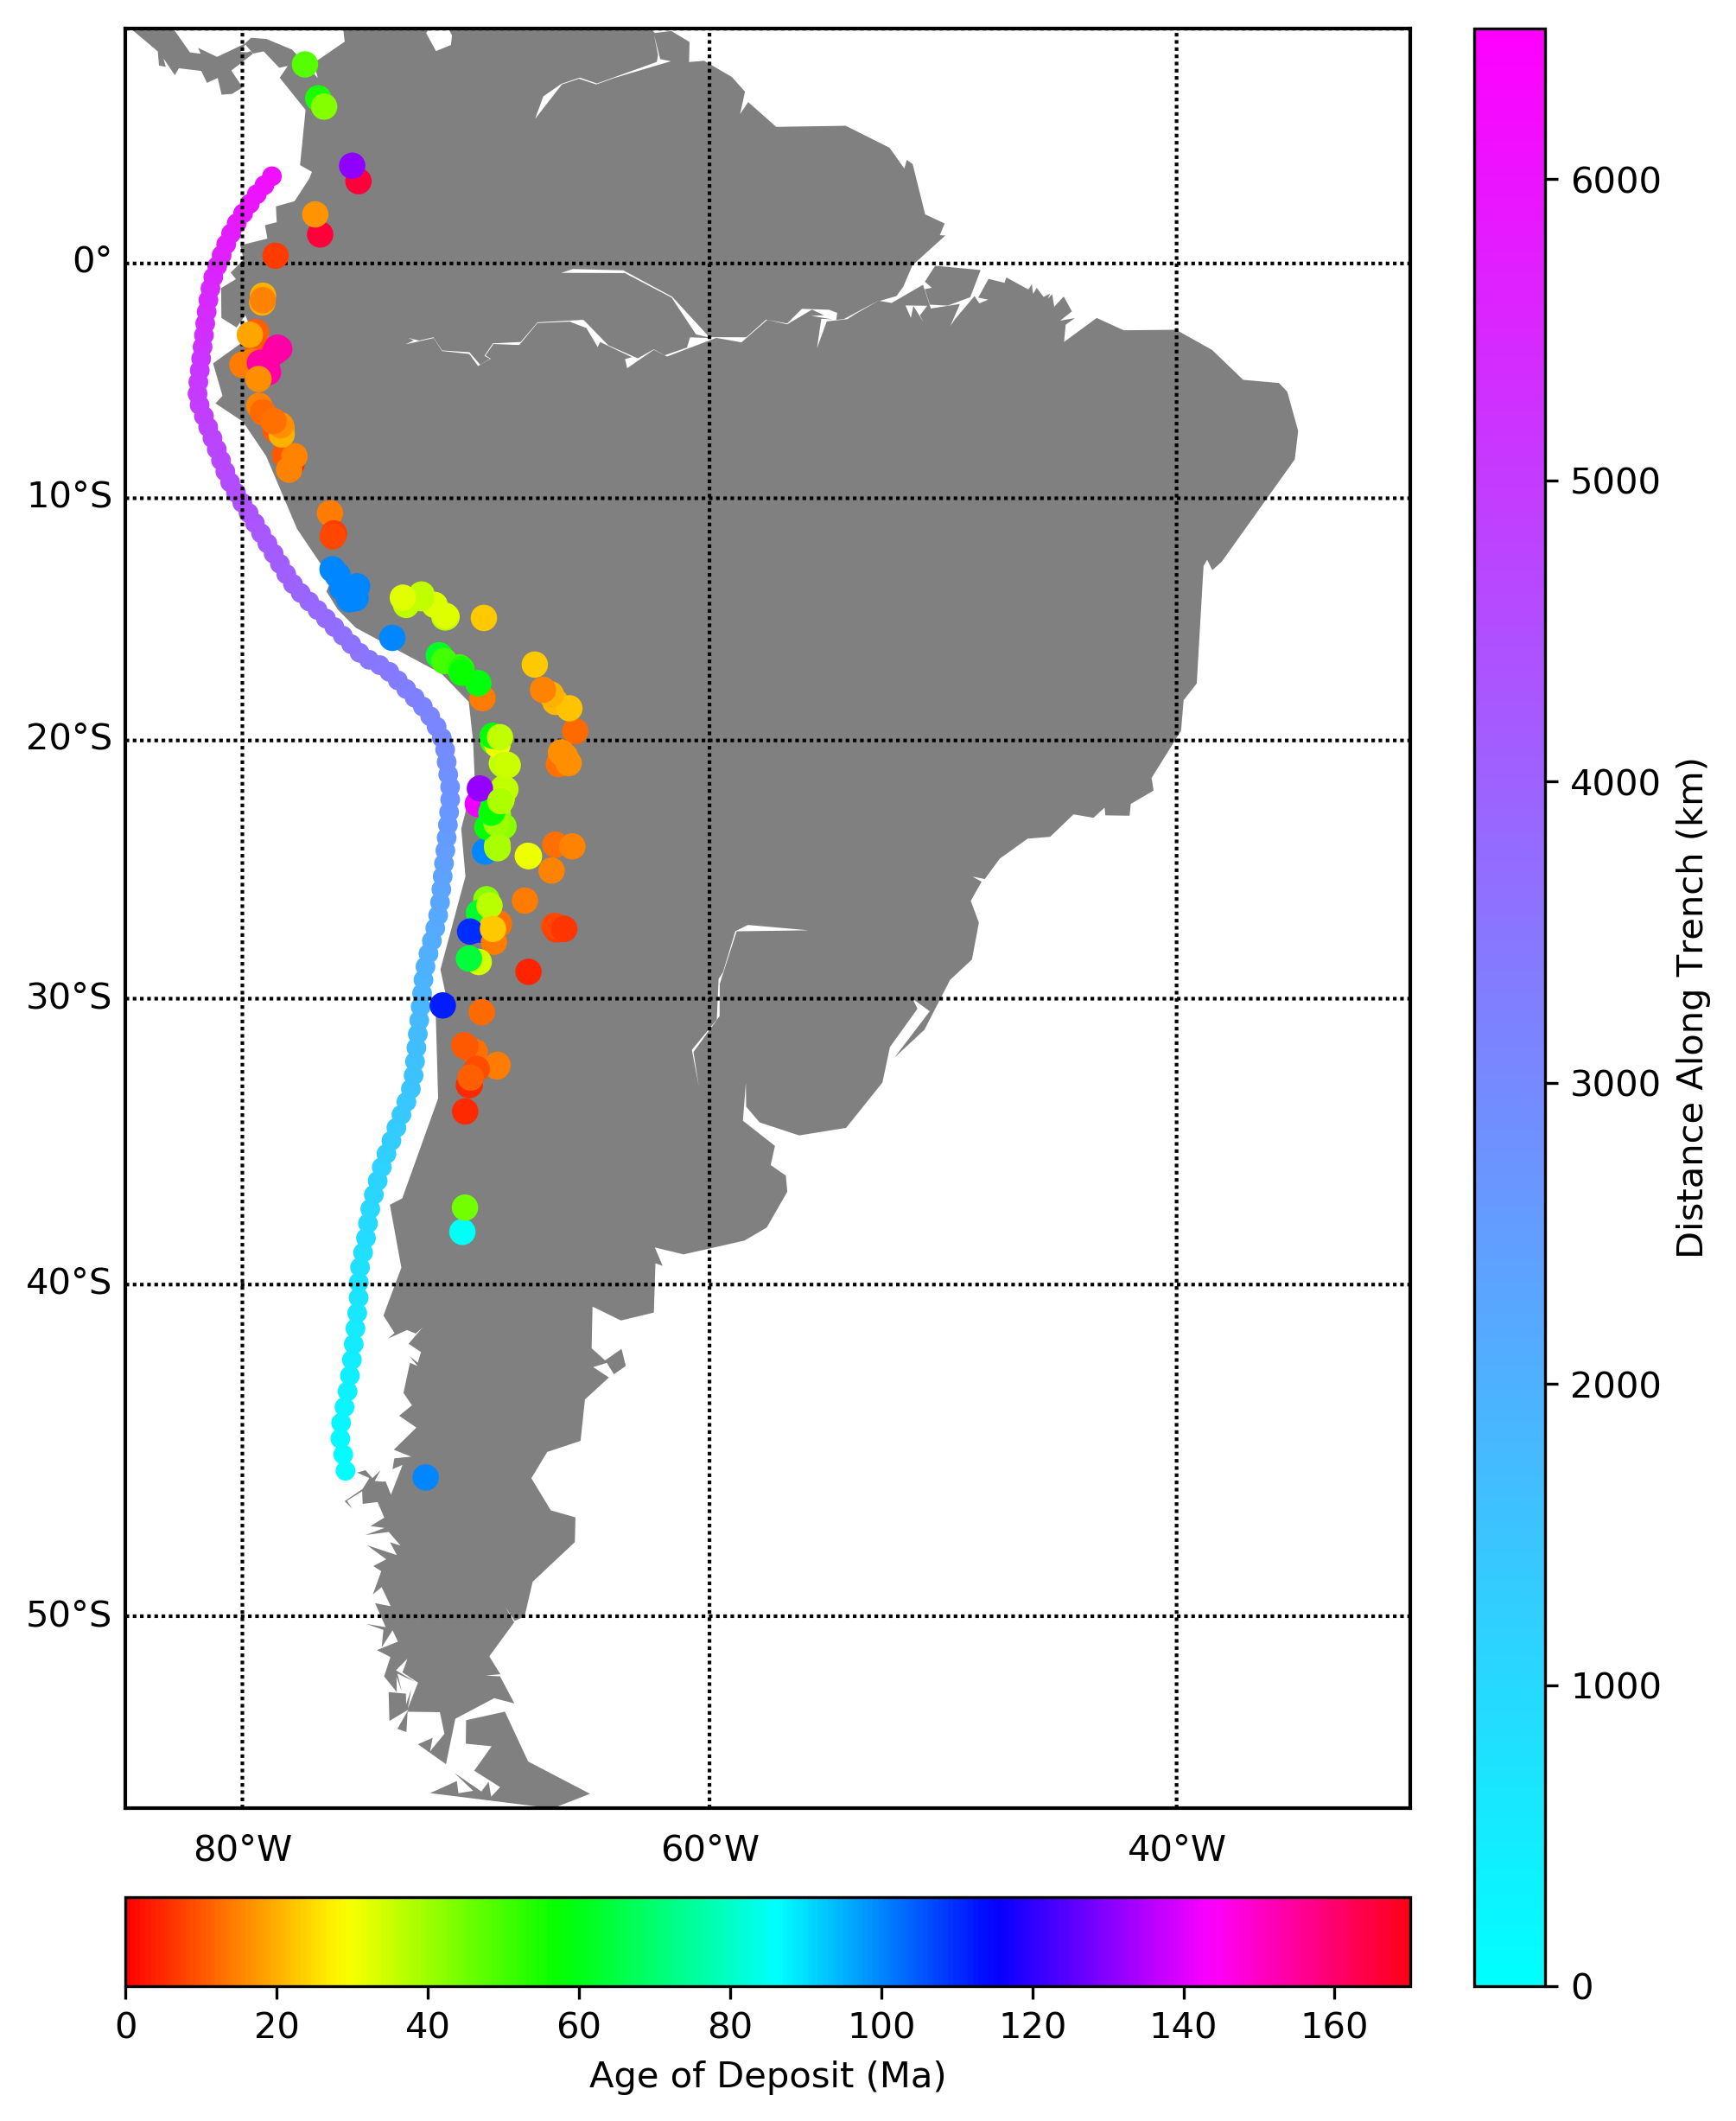

In [4]:
#Plot the ore points and the length of the trench
fig = plt.figure(figsize=(10,10),dpi=300)
pmap=Basemap(projection='merc',llcrnrlat=-55,urcrnrlat=10,\
            llcrnrlon=-85,urcrnrlon=-30,lat_ts=0,resolution='c')

pmap.drawmapboundary(fill_color='white')
pmap.fillcontinents(color='grey', lake_color='white', zorder=0)
pmap.drawmeridians(numpy.arange(0, 360, 20),labels=[0,0,0,1],fontsize=10)
pmap.drawparallels(numpy.arange(-90, 90, 10),labels=[1,0,0,0],fontsize=10)


#Plate polygons are removed for paper distribution. These can be exported from GPlates.
#Load in plate polygons for plotting
# topologyFile='topology_platepolygons_0.00Ma.shp'
# [recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(topologyFile)

# #Plot the plate polygons
# for i, nshp in enumerate(xrange(Nshp)):
#     if nshp!=24 and nshp!=3:
#     #These are the Pacific and Australian plates, they cross the dateline and cause 
#         banding errors
#         print nshp, recs[nshp][8]
#         polygonShape=shapes[nshp].points
#         poly=np.array(polygonShape)
#         xh, yh = pmap(poly[:,0], poly[:,1])
#         l2 = pmap.plot(xh, yh, c='k',zorder=1)


#Plot the South American present day trench
xh, yh = pmap(andesPresent2[:,0,0],andesPresent2[:,0,1])

l1 = pmap.scatter(xh, yh, 30, marker='o', c=andesPresent2[:,0,18],
                  edgecolor='none',zorder=2,cmap=plt.cm.cool)
cbar=pmap.colorbar(l1,location='right',pad="5%")
plt.clim(0,6500)
cbar.set_label('Distance Along Trench (km)')

#Plot the ore deposits
xh, yh = pmap(d3[d3[:,0,-1]==1,0,0],d3[d3[:,0,-1]==1,0,1])
l2 = pmap.scatter(xh, yh, 40, marker='o', c=d3[d3[:,0,-1]==1,0,4],cmap=plt.cm.hsv,zorder=3)
#                   edgecolor='none')

cbar=pmap.colorbar(l2,location='bottom',pad="5%")
plt.clim(0,170)
cbar.set_label('Age of Deposit (Ma)')


#plt.title('Andes Porphyry Magmatism')
    
plt.show()



We need to merge these two datasets together, so that the cumulative sum of distance along the orignal profile is known by the ore deposit data. i.e, each ore deposits needs to find its closest associated point along the trench.

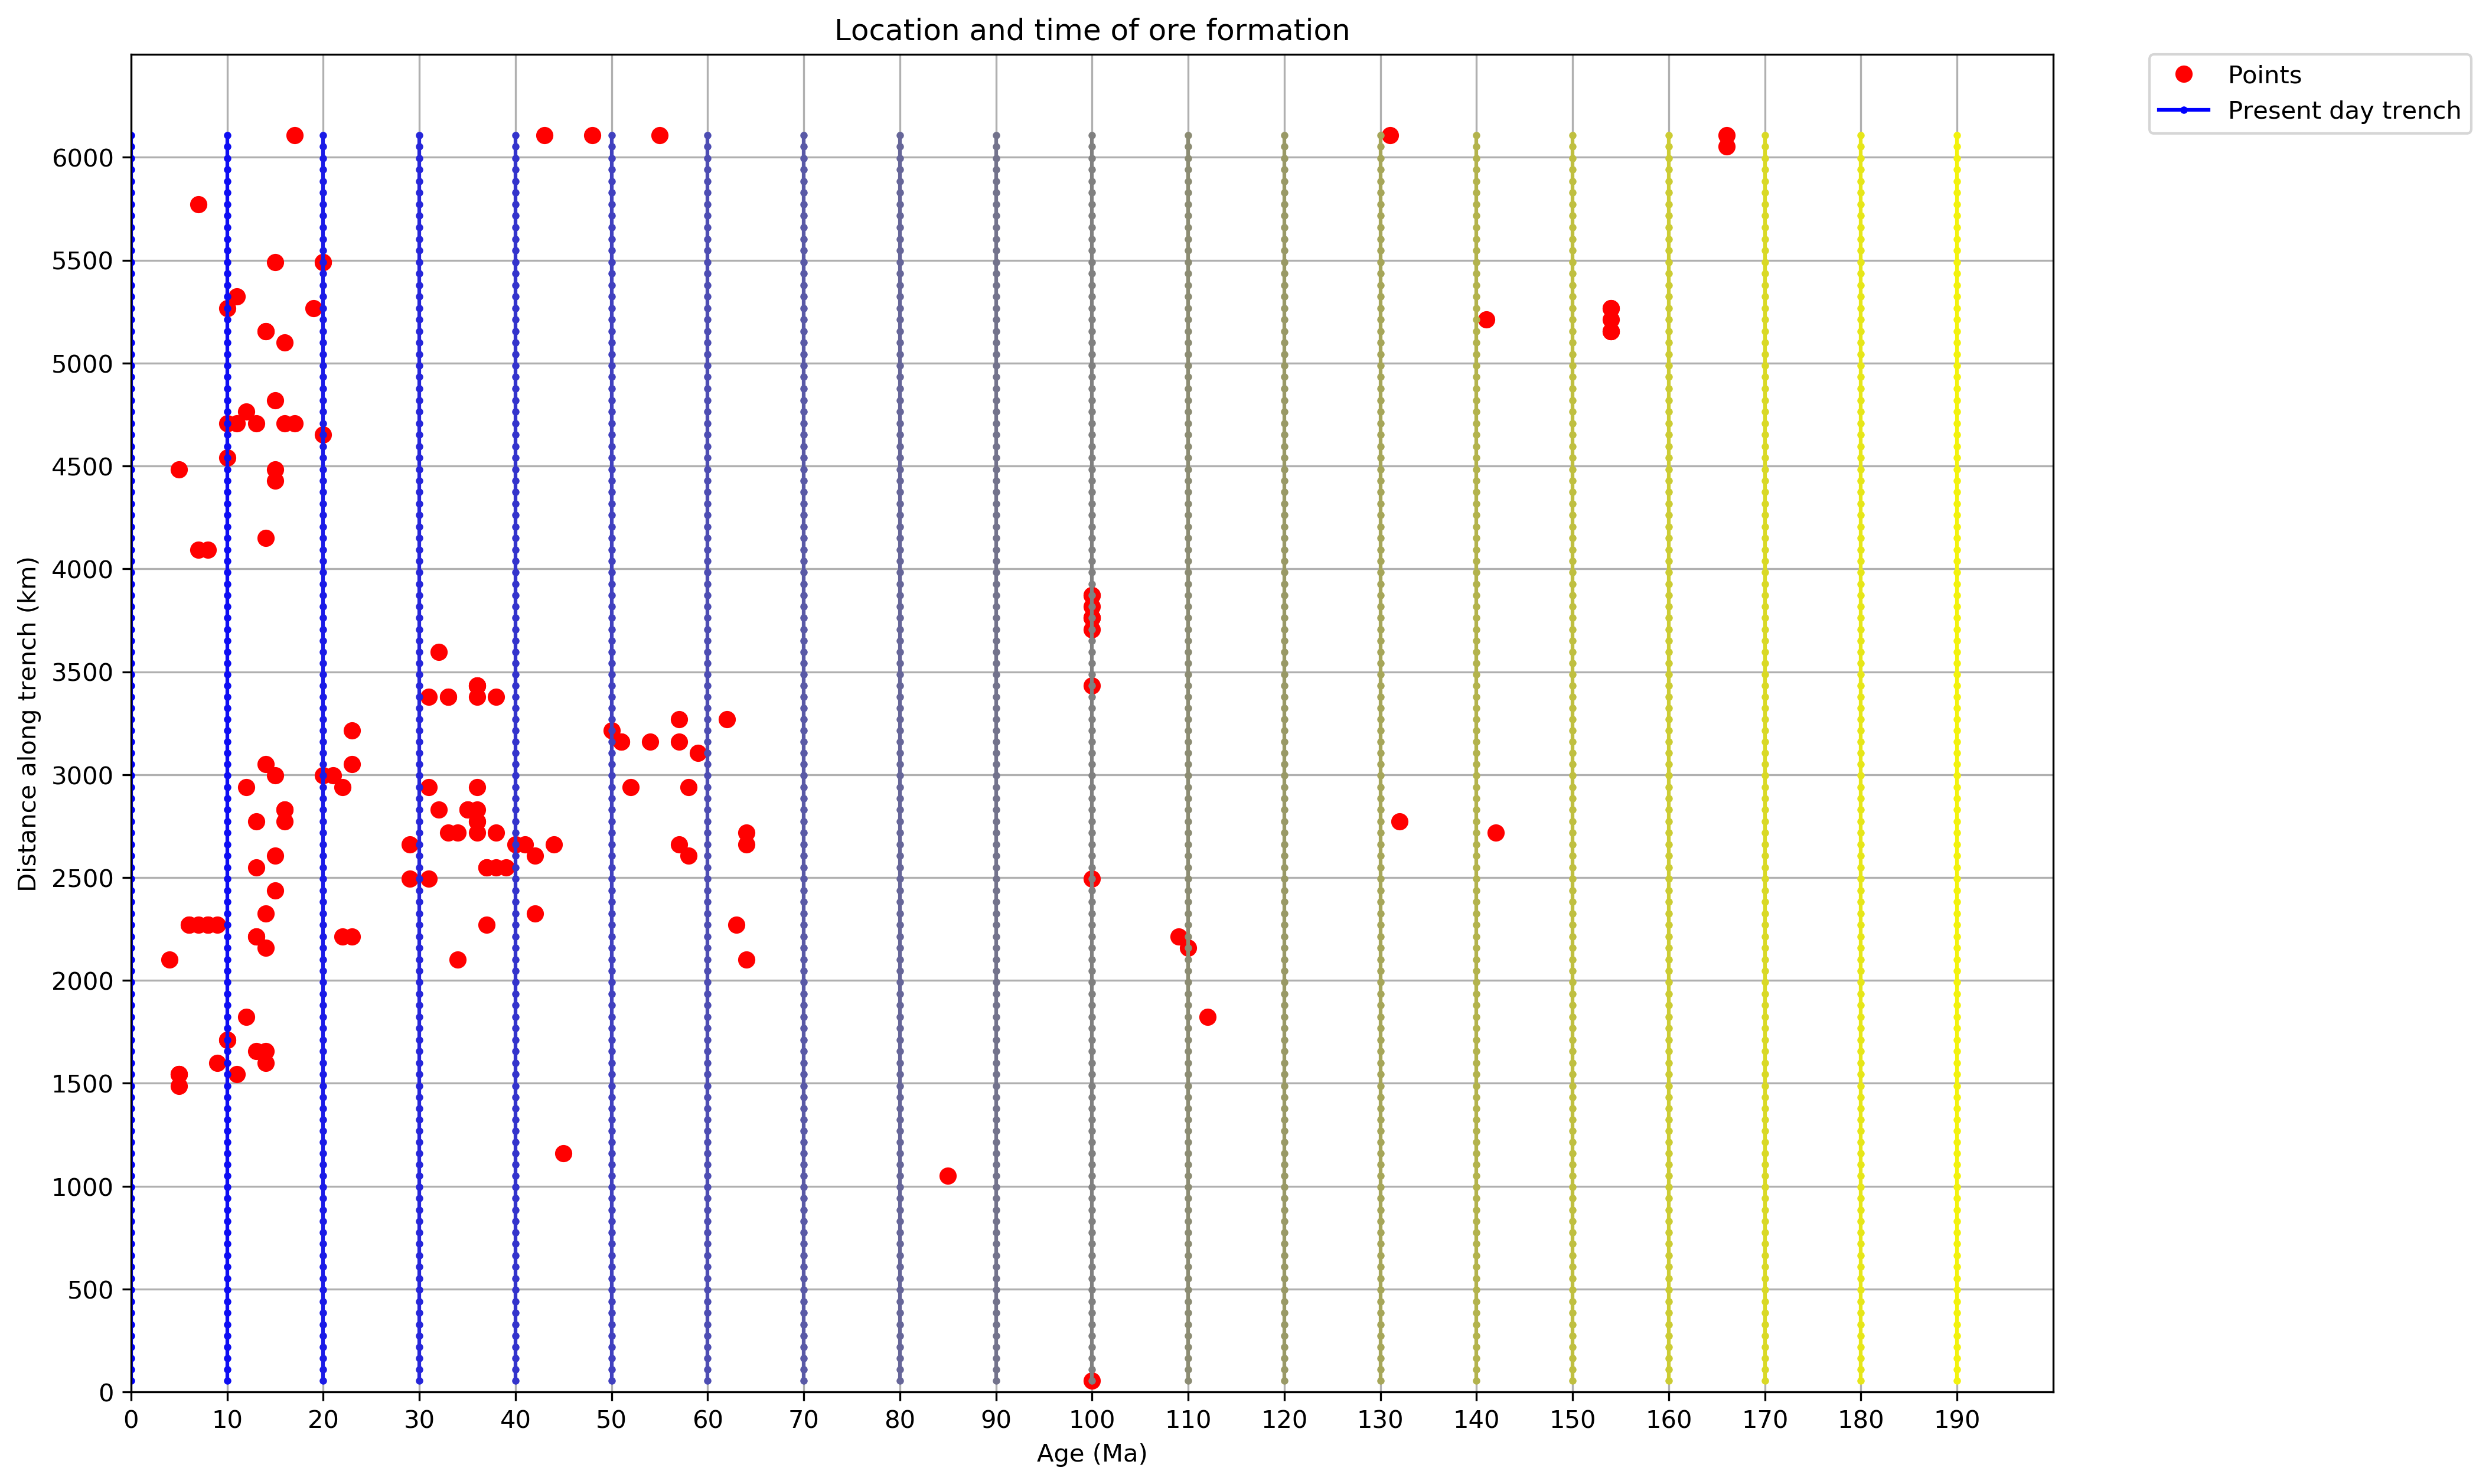

In [5]:
#Make a figure demonstrating this
fig = plt.figure(figsize=(14,10),dpi=300) 
ax = fig.add_subplot(111) 

#plot all the age and location along SAM of all the data points
ax.plot(d3[d3[:,0,-1]==1,0,4]+d3[d3[:,0,-1]==1,0,5],d3[d3[:,0,-1]==1,0,18],'ro')
    
#Plot the present day trench through time
for i in range(0,200,10):
    mycolor=[(i)/200.0,(i)/200.0,1-(i)/200.0]
    plt.plot(andesPresent2[:,i,4]+andesPresent2[:,i,5],andesPresent2[:,0,18],\
    #plt.plot(andesPresent[:,i,4]+andesPresent[:,i,5],range(len(andesPresent[:,i,4])),\
             color=mycolor,markersize=6, markeredgecolor='None',marker='.')

#Add details to plot
plt.legend(["Points","Present day trench"],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1)

plt.title('Location and time of ore formation')
plt.ylabel('Distance along trench (km)')
plt.xlabel('Age (Ma)')

plt.xlim([0,200])
plt.ylim([0,6500])
ax.set_xticks(np.arange(0,200,10)) 
ax.set_yticks(np.arange(0,6500,500)) 
plt.grid()

plt.show()

This is the partioing of the data. 
Split the data into 500 km x 10 Myr (both these numbers are somewhat arbitrary but based on estimates for the sizes of porphyry deposits).
We focus on the tectonomagmatic parameters of each space and see if it produces an ore deposit or not.

Number of spatial domains:  13
Number of temporal domains:  17
Number of total domains:  221


/Users/nbutter/anaconda3/envs/pyforgeo/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: Mean of empty slice


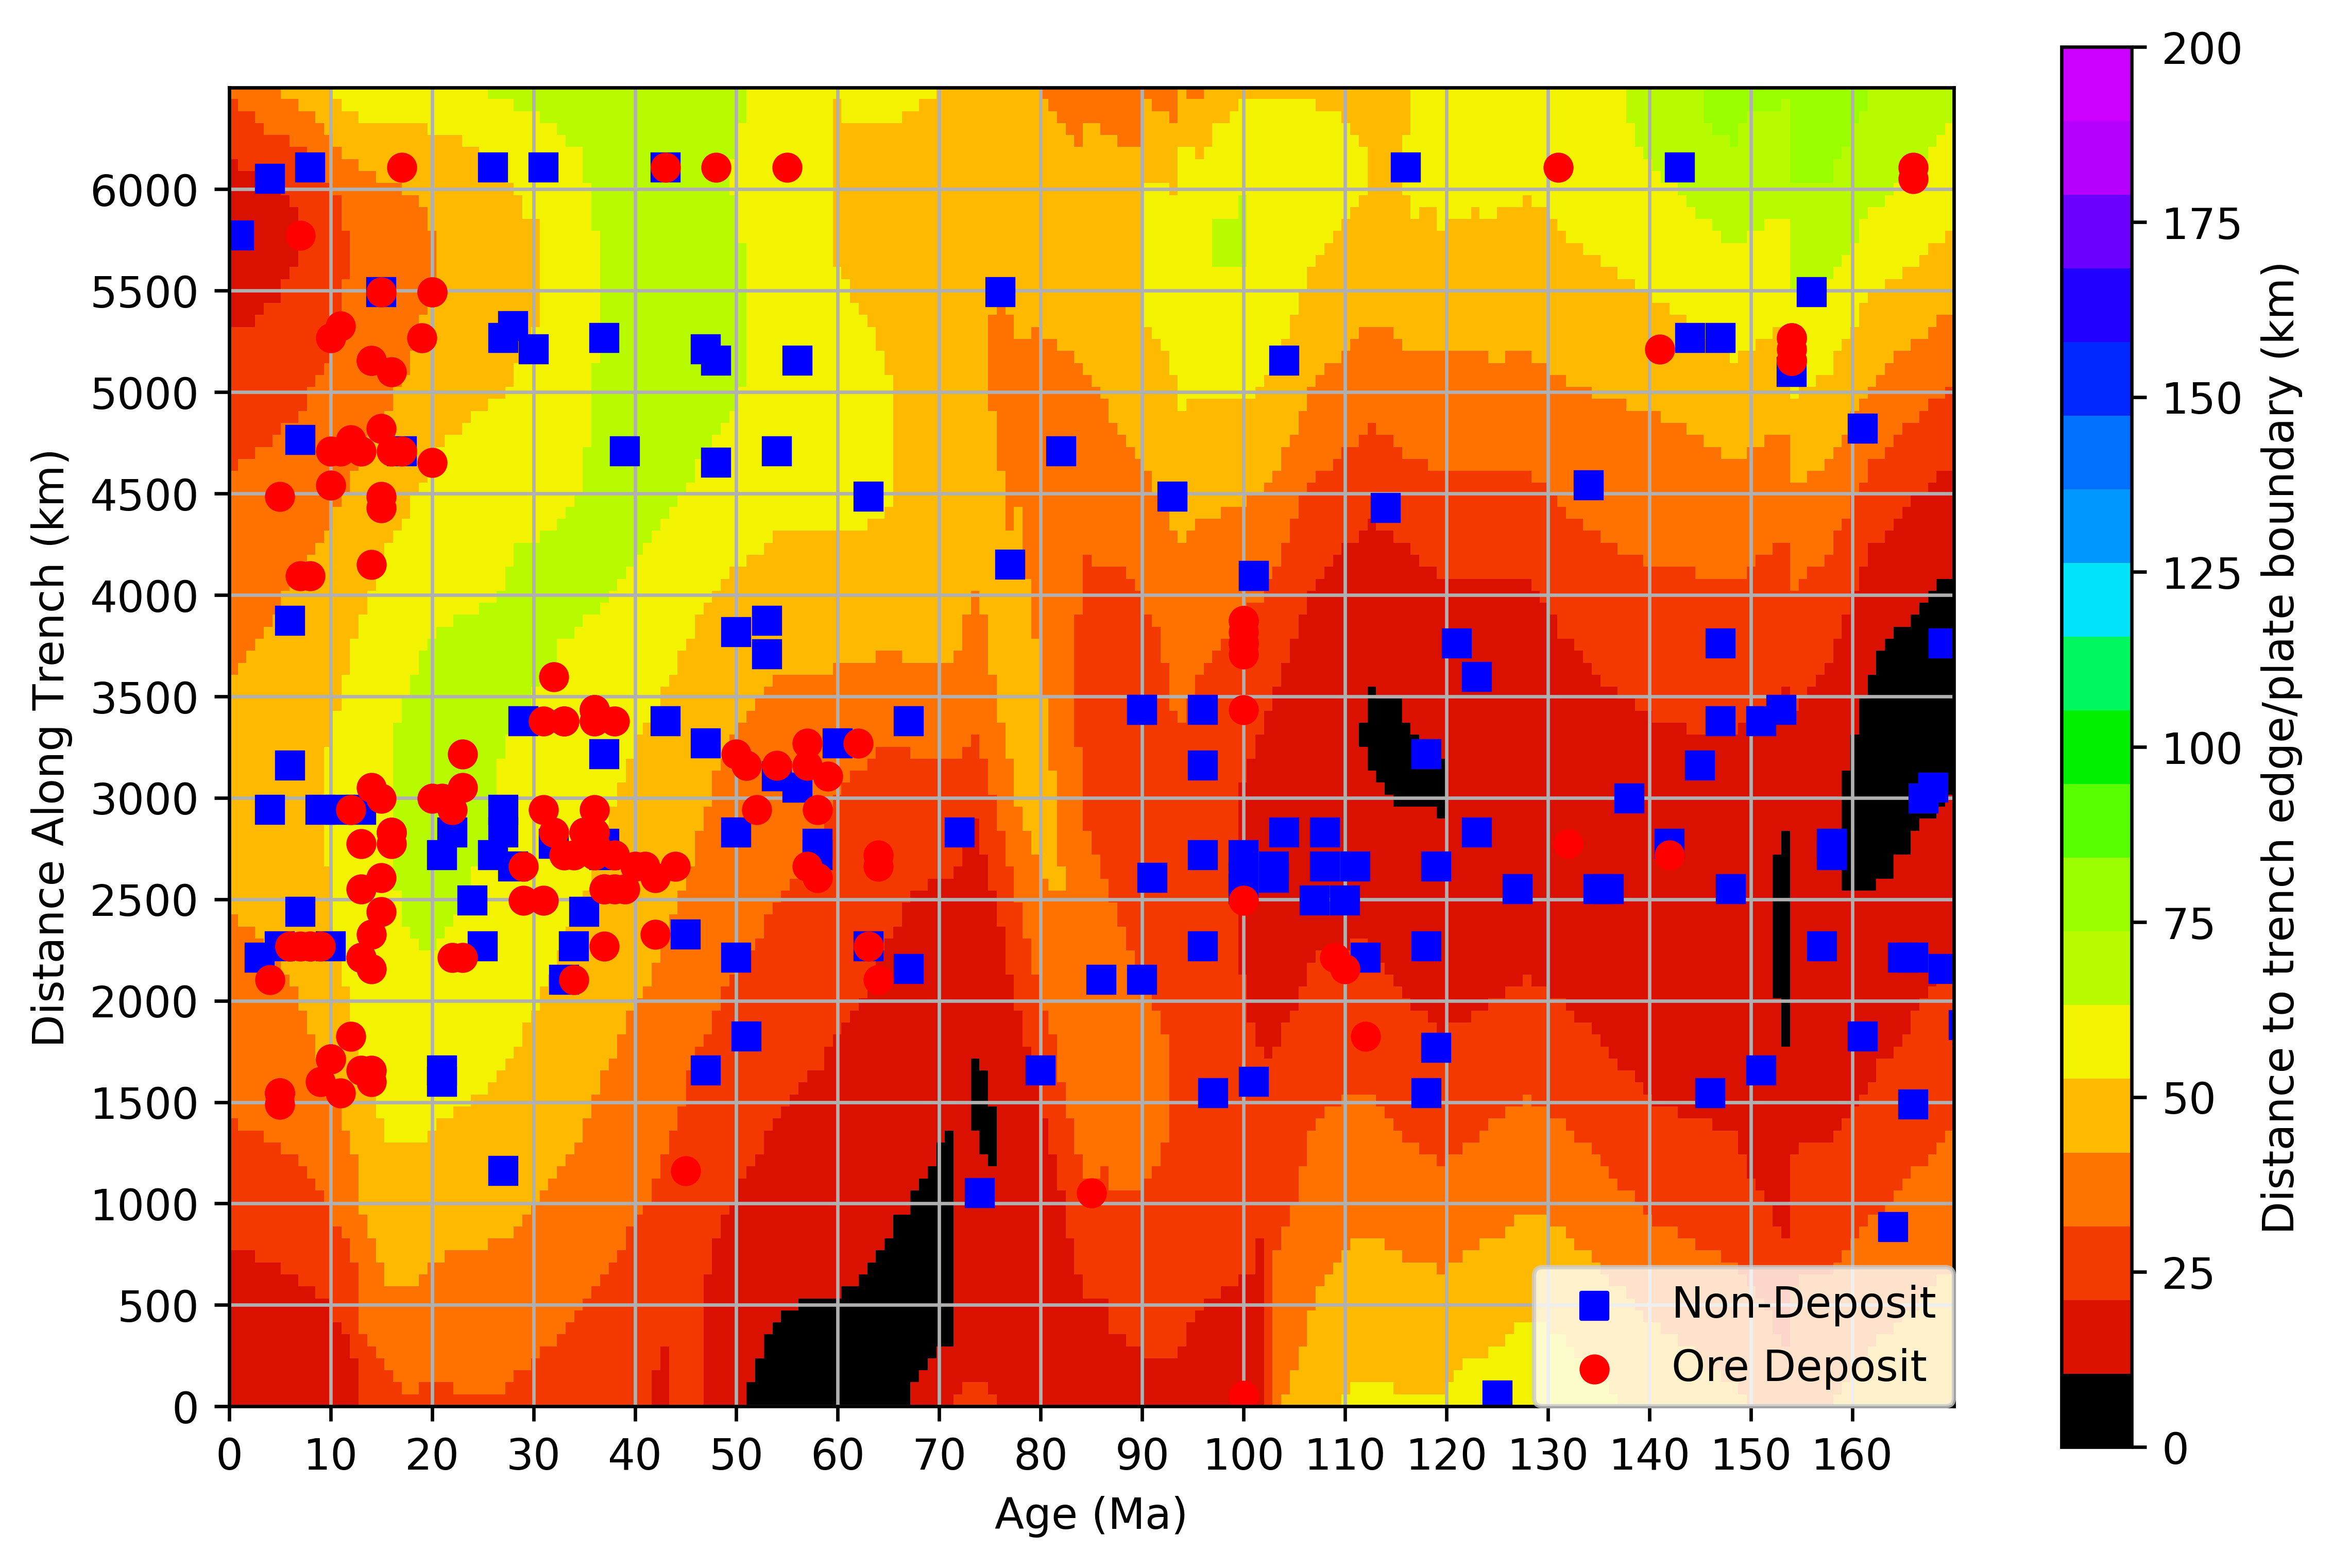

In [6]:
#Plot the combined datasets through all time and space. And (more importantly) save each 
# partioned  segment of the data, stating whether there is an ore deposit or not

#Initiliase the figure
fig = plt.figure(figsize=(9,6),dpi=600) 
ax = fig.add_subplot(111) 

#Retrieve a colour map
age_cmap=colormap_age()

#Plot the dataset, change the dataset you want to show
plt.imshow(andesPresent2[:,0:200,6],\
           #extent=[0,170,andesPresent2[-1,0,18],andesPresent2[0,0,18]],aspect=0.02,\
           extent=[0,170,6500,0],aspect=0.02,\
           cmap=age_cmap,vmin=0,vmax=200) #Seafloor age 6
           #cmap=plt.cm.RdBu_r,vmin=-200,vmax=200) #Convergence Rate 14
           #cmap=plt.cm.PuOr,vmin=-90,vmax=90) #Subduction Obliquity 17 degs, 19 rads
           #cmap=plt.cm.rainbow,vmin=0,vmax=3000) #Distance from Plate Boundary 9


#plt.clim(0,70)
plt.gca().invert_yaxis()
cbar=plt.colorbar()
cbar.location='bottom'
#cbar.set_label('Age of Subducting Lithosphere (Myr)') #6
#cbar.set_label('Orthogonal Plate Convergence (km/Myr)') #14
#cbar.set_label('Subduction Obliquity (radians)') #17 degs 19 signed rads
cbar.set_label('Distance to trench edge/plate boundary (km)') #9


#Make an empty array to store each segmented dataset
partionedData=[]

#Now plot where all the Ore deposits fall
#make an array for coloring the points
k=0

#Plot the non-deposit, 'random' data 
data1=d3[d3[:,0,20]==0,0,4]+d3[d3[:,0,20]==0,0,5] 
data2=d3[d3[:,0,20]==0,0,18]

for i in range(0,len(data1),1):
    #mycolor=[0.6,0.9,(i+0.1)/float(len(data1))]
    ax.plot(data1[i],data2[i],\
             color='b',marker='s',linestyle='None',lw=0.)

#Plot the ore deposit data 
data1=d3[d3[:,0,20]==1,0,4]+d3[d3[:,0,20]==1,0,5] 
data2=d3[d3[:,0,20]==1,0,18]

for i in range(0,len(data1),1):
    #mycolor=[(i+0.1)/float(len(data1)),(i+0.1)/float(len(data1)),(i+0.1)/float(len(data1))]
    ax.plot(data1[i],data2[i],\
             color='r',marker='o',linestyle='None',lw=0.)
    
    #print d3[i,0,6], mycolor #Check with parameter colouring
    


##THIS IS WHERE THE SPATIO-TEMPORAL BIN PARAMETERS ARE SET

print("Number of spatial domains: ", len(range(0,6500,500))) 
print("Number of temporal domains: ",len(range(0,170,10)))
print("Number of total domains: ", len(range(0,6500,500))*len(range(0,170,10)))

#Change the extent of the next 2 for-loops and iterators to change resolution of intervals and impose space-time restrictions
#Loop through the 6500km length of the Andean Margin in 500km increments #max length is actually 6107km
for i in range(0,6100,500):
    j=i+500
    
    #Loop through all time in 10Myr increments, change here to restrict time
    for t1 in range(0,170,10):
        t2=t1+10
        
        #Extract just the parts of the data we want
        bin1=numpy.where(d3[:,0,18]>=i)
        andesTemp1 = cleanCondition(bin1,d3)
        bin2=numpy.where(andesTemp1[:,0,18]<j)
        andesTemp2 = cleanCondition(bin2,andesTemp1)
        bin3=numpy.where(andesTemp2[:,0,4]>=t1)
        andesTemp3 = cleanCondition(bin3,andesTemp2)
        bin4=numpy.where(andesTemp3[:,0,4]<t2)
        
        andesData = cleanCondition(bin4,andesTemp3)
        
        bin1=numpy.where(andesPresent2[:,0,18]>=i)
        andesTemp1 = cleanCondition(bin1,andesPresent2)
        bin2=numpy.where(andesTemp1[:,0,18]<j)
        andesTemp2 = cleanCondition(bin2,andesTemp1)
                
        andesProfile = andesTemp2[:,t1:t2,:]

        andesProfile = numpy.nanmean(numpy.nanmean(andesProfile,axis=0),axis=0)
        
        #Check if that domain has or deposit or not.
        if len(andesData) > 0:
            #If it does store a 1
            if andesData[0][0][-1]==1:
                partionedData.append(numpy.append(andesProfile,1))
            #If it does not store a 0
            else:
                partionedData.append(numpy.append(andesProfile,0))
        
        #If it does not store a 0        
        else:
            partionedData.append(numpy.append(andesProfile,0))
        


#Label the plot
plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.xlim([0,170])
#plt.ylim([-50,10])
plt.ylim([0,6500])
ax.set_xticks(np.arange(0,170,10)) 
ax.set_yticks(np.arange(0,6500,500)) 
plt.grid()

#Make a legend
Z = [[-10,-10],[-10,-10]] #With dummy variables
p1=ax.scatter(Z[0],Z[1],marker='s',c='b')
p2=ax.scatter(Z[0],Z[1],marker='o',c='r')
ax.legend([p1,p2],["Non-Deposit","Ore Deposit"],
           bbox_to_anchor=(1, 0), loc=4, borderaxespad=0.,numpoints=1)

plt.show()

In [9]:
columns=('0 Present day longitude (degrees)','1 Present day latitude (degrees)','2 Reconstructed longitude (degrees)','3 Reconstructed latitude (degrees)','4 Age (Ma)','5 Time before mineralisation (Myr)','6 Seafloor age (Myr)','7 Segment length (km)','8 Slab length (km)','9 Distance to trench edge (km)','10 Subducting plate normal velocity (km/Myr)','11 Subducting plate parallel velocity (km/Myr)','12 Overriding plate normal velocity (km/Myr)','13 Overriding plate parallel velocity (km/Myr)','14 Convergence normal rate (km/Myr)','15 Convergence parallel rate (km/Myr)','16 Subduction polarity (degrees)','17 Subduction obliquity (degrees)','18 Distance along margin (km)','19 Subduction obliquity signed (radians)','20 Ore Deposits Binary Flag (1 or 0)')

In [7]:
#Convert to a numpy array for easier manipulation and plotting
aaa=numpy.array(partionedData)

print("Shape of data array: ", aaa.shape)

#Number of 'positive' and 'negative' examples
print("Positive (deposits) examples: ",np.shape(aaa[aaa[:,20]==1,:]))
print("Negative (non-deposits) examples: ",np.shape(aaa[aaa[:,20]==0,:]))

#Check for NAN..
print("Are there NANs?", numpy.isnan(numpy.sum(aaa)))

Shape of data array:  (221, 21)
Positive (deposits) examples:  (45, 21)
Negative (non-deposits) examples:  (176, 21)
Are there NANs? False


In [10]:
import pandas
newframe=pandas.DataFrame(data=aaa,columns=columns)

In [12]:
newframe.to_csv("ml_data_panda.csv")

In [8]:
numpy.savetxt("ml_data.csv",aaa,delimiter=',')

In [18]:
bbb=pandas.read_csv("ml_data_panda.csv",index_col=0)
print(bbb.values)


[[ -7.55453478e+01  -4.38889344e+01  -7.48226824e+01 ...,   2.74581570e+02
    2.28928492e-01   0.00000000e+00]
 [ -7.55453478e+01  -4.38889344e+01  -7.29495034e+01 ...,   2.74581570e+02
    2.52075818e-01   0.00000000e+00]
 [ -7.55453478e+01  -4.38889344e+01  -7.03943287e+01 ...,   2.74581570e+02
    4.47522036e-01   0.00000000e+00]
 ..., 
 [ -7.88968250e+01   3.53884500e+00  -4.37742830e+01 ...,   6.07967878e+03
    5.31168460e-01   0.00000000e+00]
 [ -7.88968250e+01   3.53884500e+00  -4.45398272e+01 ...,   6.07967878e+03
    9.15569596e-01   0.00000000e+00]
 [ -7.88968250e+01   3.53884500e+00  -4.40405094e+01 ...,   6.07967878e+03
    1.08765801e+00   1.00000000e+00]]
[[ -7.55453478e+01  -4.38889344e+01  -7.48226824e+01 ...,   2.74581570e+02
    2.28928492e-01   0.00000000e+00]
 [ -7.55453478e+01  -4.38889344e+01  -7.29495034e+01 ...,   2.74581570e+02
    2.52075818e-01   0.00000000e+00]
 [ -7.55453478e+01  -4.38889344e+01  -7.03943287e+01 ...,   2.74581570e+02
    4.47522036e-01   

#PART II 
#Machine Learning
Now we use our datasets to determine what tectonomagmatic parameters are related to ore formation. We use Support Vector Machines and Random Forrest classification methods. This notebook shows the two methods of data analysis, either looking at the general area of ore formation, or considering each ore formation point individually.


##Area of formation (Partioned Data)

####Split the data into testing and training sets.
With the "training" set we learn which parameters are important, and we test the validity of this with the "testing" set.

In [7]:
#Put the data into the correct format

#Get the parameters we want to include in the ML, indicies are from the List of Variables
params=[6,9,14,17] 
# params=[6,9,10,11,12,13,14,15,16,17]

#Recombine the features and the classification vectors. #Save the temporal-spatial parameters too for plotting purposes.
andesData = numpy.c_[preprocessing.scale(aaa[:,params]),aaa[:,5],aaa[:,18],aaa[:,20]]

#Do a 80/20 split of the data  to be used to make an example fit of the data
andesTrain, andesTest,  = cross_validation.train_test_split(\
       andesData, test_size=0.2, random_state=1)

print("Shape of data array: ", andesData.shape)

#Number of 'positive' and 'negative' examples
print("Positive (deposits) examples: ",np.shape(aaa[aaa[:,20]==1,:]))
print("Negative (non-deposits) examples: ",np.shape(aaa[aaa[:,20]==0,:]))

Shape of data array:  (221, 7)
Positive (deposits) examples:  (45, 21)
Negative (non-deposits) examples:  (176, 21)


#SVM
Use Support Vector Machines to learn which parameters are important.

In [8]:
#Make the classifier
clf = SVC(probability=True,verbose=True,cache_size=1000,class_weight=None)


#Now make a single classification for plotting and typicla results
#Train the classifier by fitting the parameters (features) to known results (targets/classes)
clf.fit(andesTrain[:,0:-3], andesTrain[:,-1])

print("Prediction-testing set (expected result):")
print(andesTest[:,-1])

print("Prediction of test (actual result):")
print(clf.predict(andesTest[:,0:-3]))

#Save the values of prediction
p=numpy.array(clf.predict_proba(andesTest[:,0:-3]))

#Get a single score out for the data
svmParams=clf.score(andesTest[:,0:-3], andesTest[:,-1])
print("Single result:")
print(svmParams)

# print clf.support_vectors_

###
#Now get a cross-fold validation score using all subsets of the data
scores = cross_validation.cross_val_score(clf, andesData[:,0:-3], andesData[:,-1], cv=5)

print("Cross fold validation results:")
print(scores)

#print clf.n_support_

[LibSVM]Prediction-testing set (expected result):
[ 1.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.]
Prediction of test (actual result):
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Single result:
0.711111111111
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Cross fold validation results:
[ 0.82222222  0.84090909  0.86363636  0.77272727  0.79545455]


#SVM Typical Result

Number of points used for testing:  (45,)
Shape of grid: (65, 100)


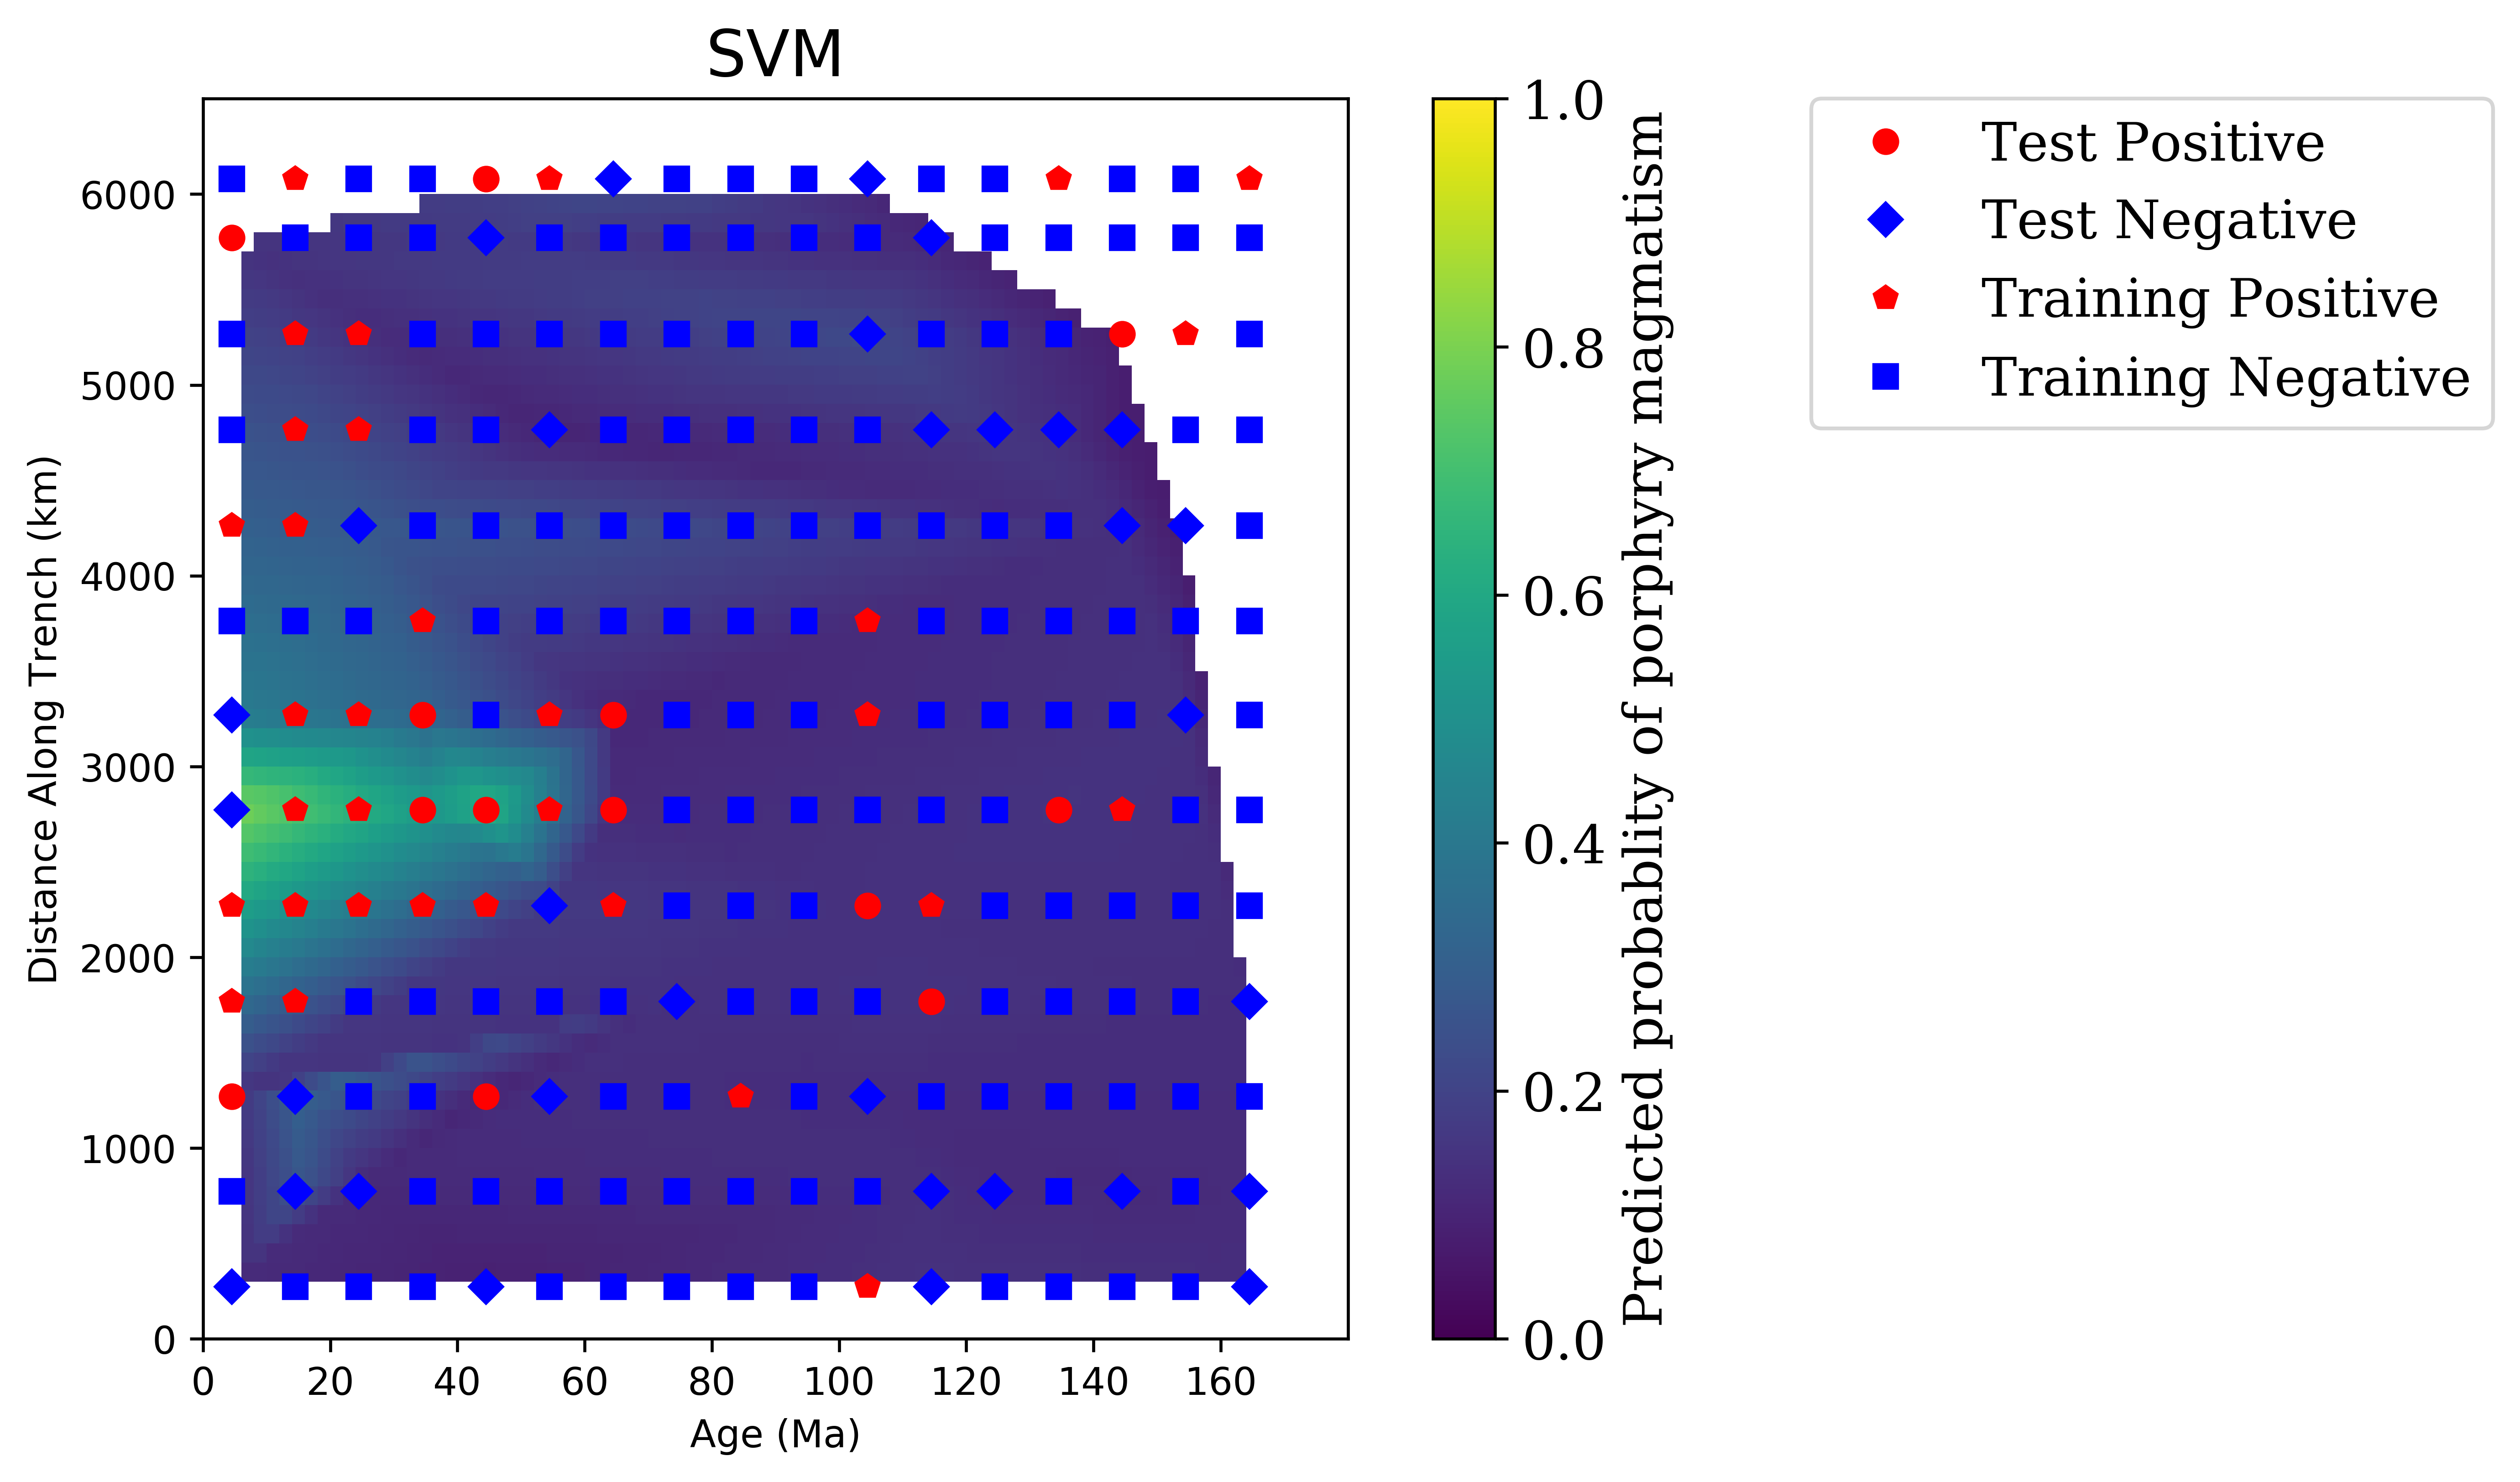

Five-fold cross validation scores:  [ 0.82222222  0.84090909  0.86363636  0.77272727  0.79545455]
SCORE Mean: 0.82 STD: 0.03


In [9]:
#Make some plots of typical results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have 
#formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,65))
#Retrieve the ML scores
values = p[:,1].flatten()
print("Number of points used for testing: ", np.shape(values))

#Now grid the data
grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print("Shape of grid:", np.shape(grid_z1))

#Plot the new grid
fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')


#Plot each of the result vectors
#Plot the testing data
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#Plot the training data
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#Create the legend
plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)

#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('SVM')

plt.show()

print("Five-fold cross validation scores: ", scores)
print('SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores))

#Random Forest Classification
Try a Random Forest classification also

In [10]:
print('Running...')
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)


#Now make a single classification for plotting and typical results
print('Fitting...')
rf.fit(andesTrain[:,0:-3], andesTrain[:,-1])

#predicted_probs = [[index + 1, x[1]] for index, x in enumerate(rf.predict_proba(testingSet))]

print('Score of test data: ', rf.score(andesTest[:,0:-3], andesTest[:,-1]))
p=numpy.array(rf.predict_proba(andesTest[:,0:-3]))
#q=numpy.array(predicted_probs)

#The Random Forest method allows us to determine what parameters preferentially optimised the test score.
print("Feature Importance: ", rf.feature_importances_)

###
#Get a cross-fold validation score using all subsets of the data
scores = cross_validation.cross_val_score(rf, andesData[:,0:-3], andesData[:,-1], cv=5)

print("Five-fold cross validation scores: ", scores)

Running...
Fitting...
Score of test data:  0.666666666667
Feature Importance:  [ 0.22309156  0.29402732  0.29734642  0.1855347 ]
Five-fold cross validation scores:  [ 0.71111111  0.81818182  0.81818182  0.77272727  0.79545455]


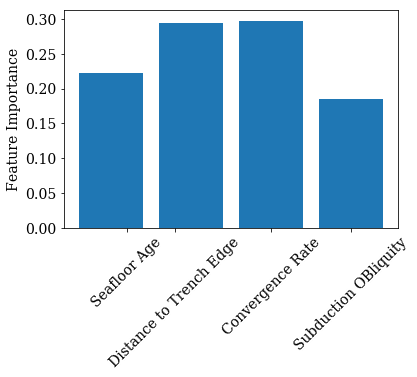

Feature Importance:  [ 0.22309156  0.29402732  0.29734642  0.1855347 ]


In [11]:
#Plot of feature importance
paramLabels=["Seafloor Age","Distance to Trench Edge","Subducting Plate Normal", "Subducting Plate Parallel",\
             "Overriding Plate Normal", "Overriding Plate Parallel",\
             "Convergence Rate","Convergence Parallel",\
             "Subduction Polarity", "Subduction OBliquity"]
        
paramLabels=["Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction OBliquity"]

fig, ax = plt.subplots()

#rects=ax.bar([0,1,2,3,4,5,6,7,8,9,10],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8,9],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4],rf.feature_importances_)
rects=ax.bar([0,1,2,3],rf.feature_importances_)

#print len(rf.feature_importances_)

#Set the location of the tick marks
# ax.set_xticks([-0.8,-0.8,0.2,1.2,2.2,3.4,4.8,5.4,6.6,7.4])
ax.set_xticks([0.2,0.8,2.0,3.0])

# plt.ylim([0,0.35])

ax.set_xticklabels(paramLabels,rotation=45)
ax.set_ylabel('Feature Importance')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.show()

print("Feature Importance: ", rf.feature_importances_)

Number of points with an ML score:  (45,)
(45,)
(45,)
Shape of grid: (65, 100)


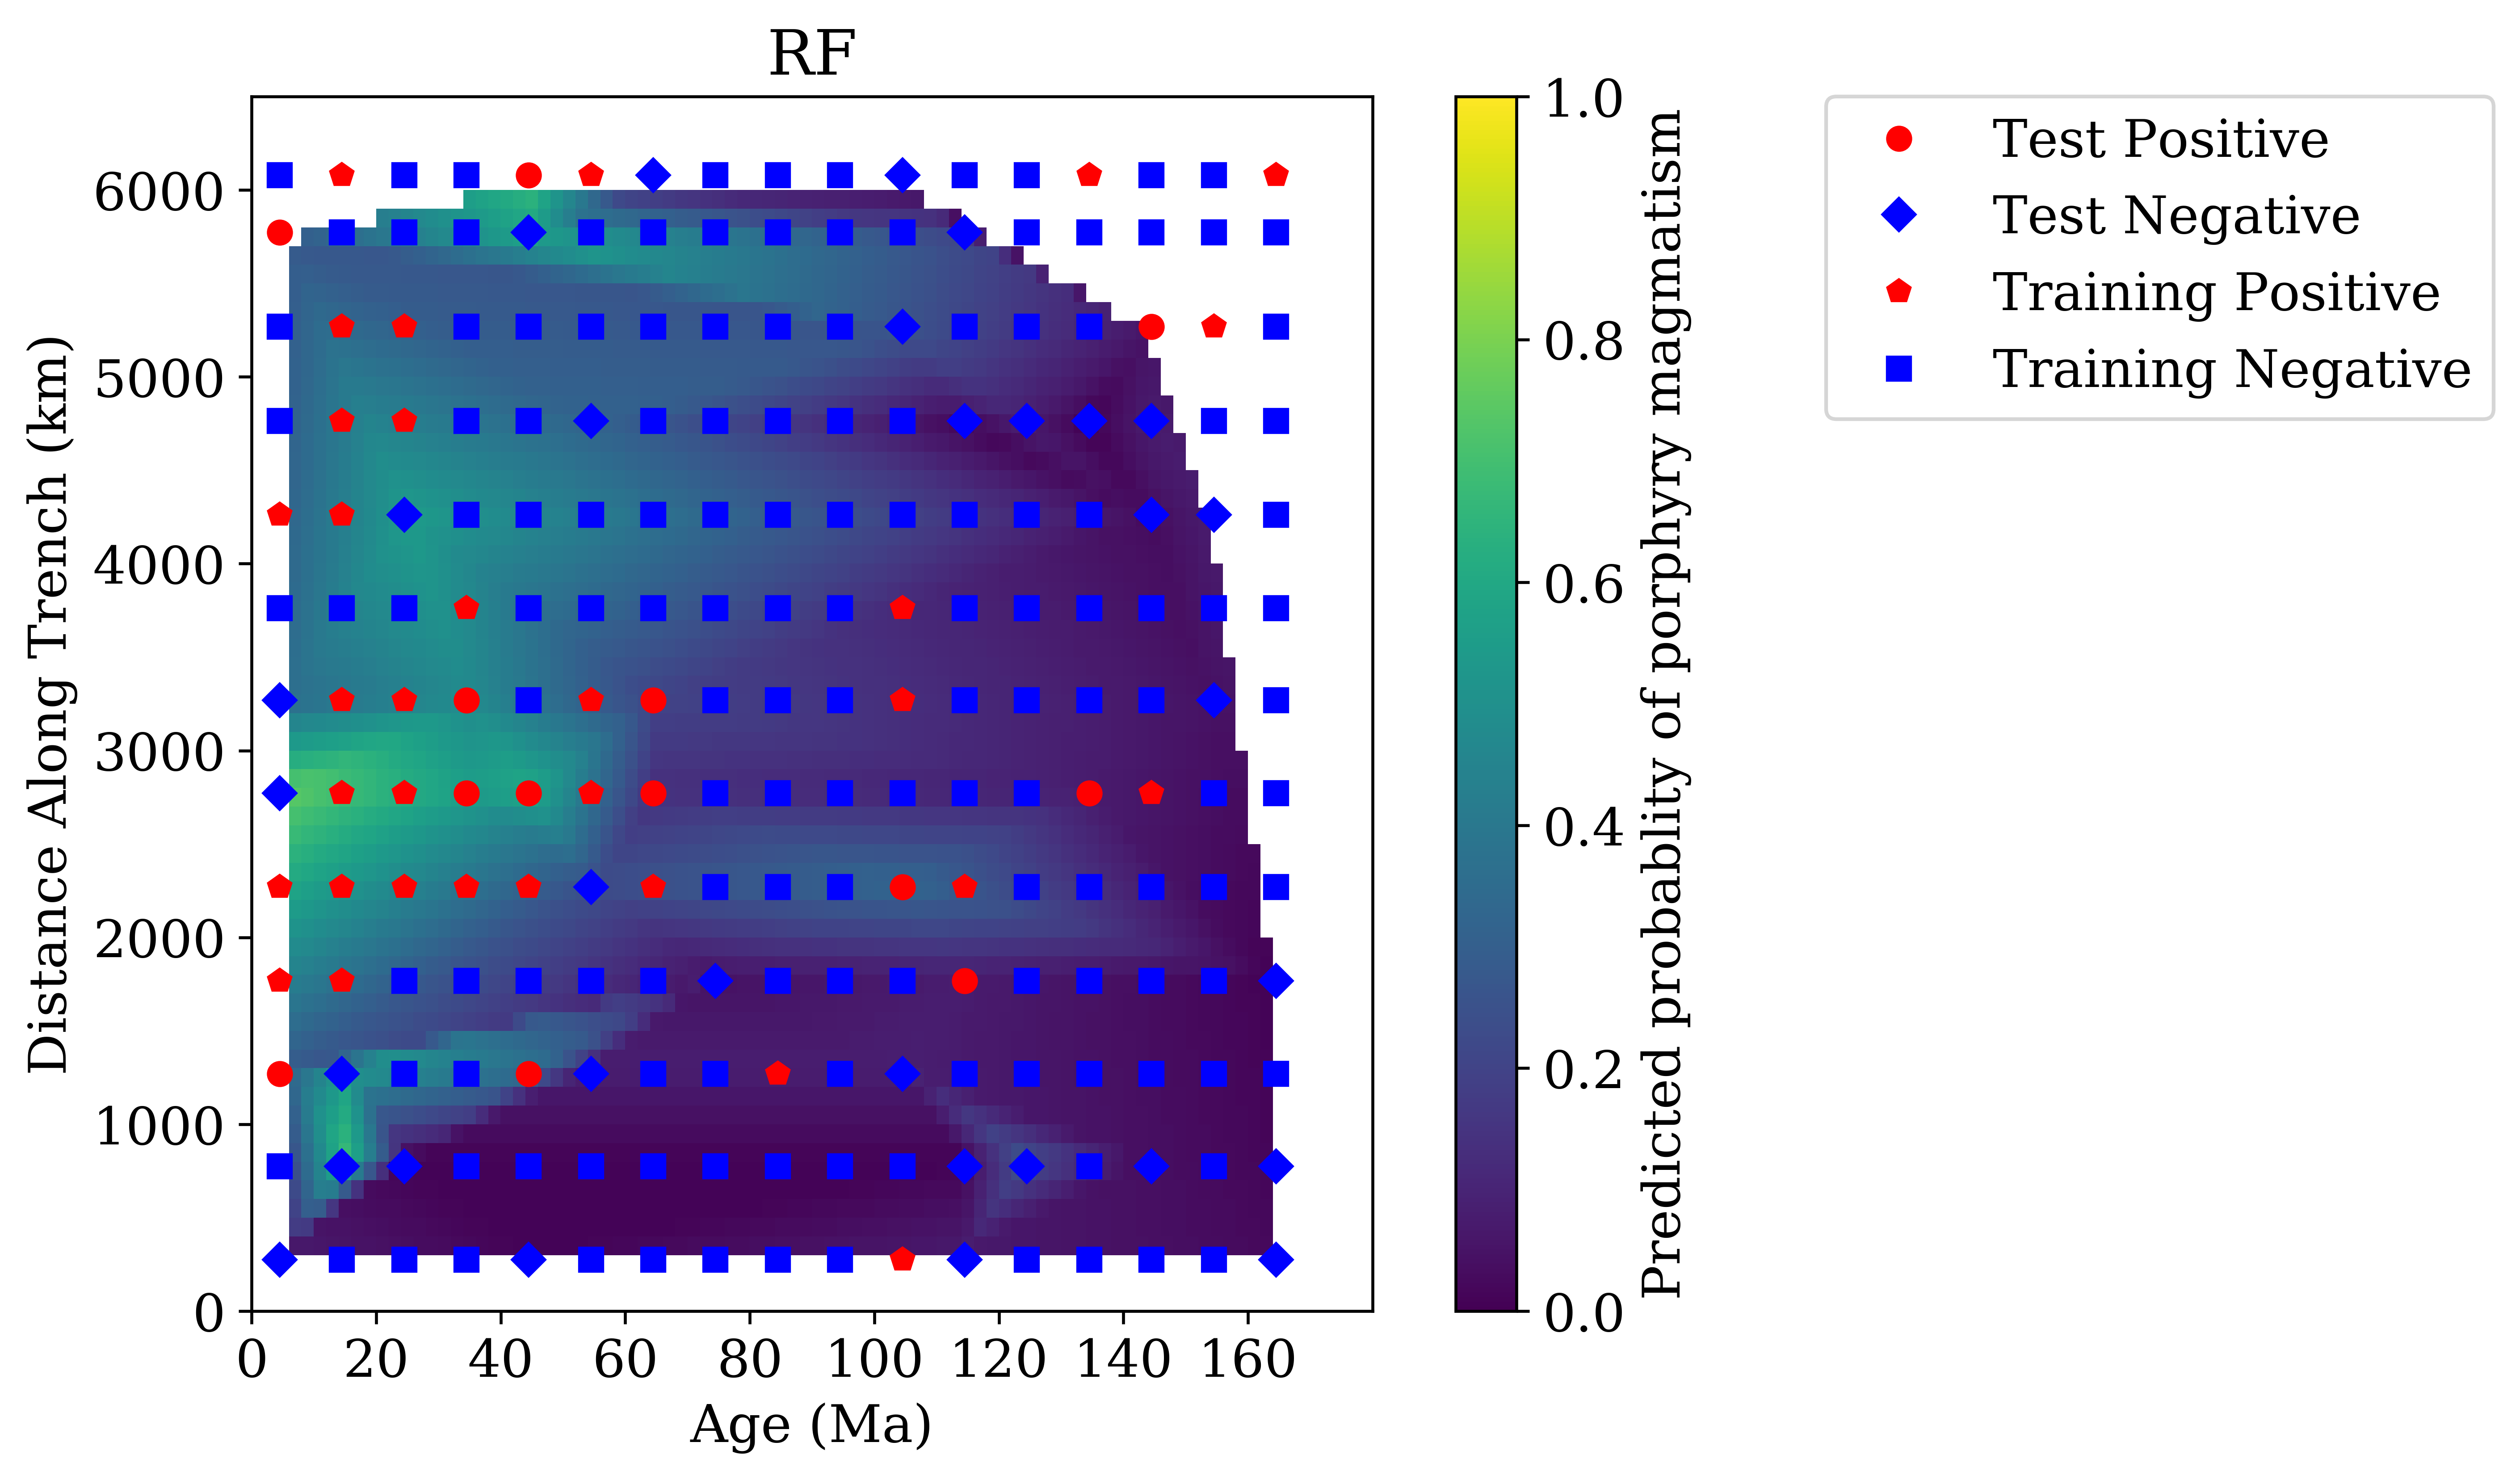

Five-fold cross validation scores:  [ 0.71111111  0.81818182  0.81818182  0.77272727  0.79545455]
SCORE Mean: 0.78 STD: 0.04


In [12]:
#Make some plots of typical results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have 
#formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,65))
#Retrieve the ML scores
values = p[:,1].flatten()
print("Number of points with an ML score: ", np.shape(values))
print(np.shape(andesTest[:,-3].flatten()))
print(np.shape(andesTest[:,-2].flatten()))
#Now grid the data
grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print("Shape of grid:", np.shape(grid_z1))

#Plot the new grid
fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')


#Plot each of the result vectors
#Plot the testing data
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#Plot the training data
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#Create the legend
plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)

#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('RF')

plt.show()

print("Five-fold cross validation scores: ", scores)
print('SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores))

#Point of formation data
Same methods as above, however the data is formatted slightly differently so we must rewrite the functions used.

###Split the data into testing and training sets.
With the "training" set we learn which parameters are important, and we test the validity of this with the "testing" set.

In [13]:
#Make a dataset for cross validation
andesTraining = d3[:,0,:]
#Time Restricted Set
# andesTraining=d3[d3[:,0,4]<70,0,:]

print("Size of data set: ", andesTraining.shape)

#Recombine the features and the classification vectors. #Save the temporal-spatial parameters too for plotting purposes.
params=[6,9,14,17] #indicies from List of Variables
# params=[6,9,10,11,12,13,14,15,16,17]
andesData = numpy.c_[preprocessing.scale(andesTraining[:,params]),andesTraining[:,4],andesTraining[:,18],andesTraining[:,20]]

#Do a 80/20 split of the data  to be used to make an example fit of the data
andesTrain, andesTest,  = cross_validation.train_test_split(\
       andesData, test_size=0.2, random_state=1)

print("Shape of data array: ", andesData.shape)

#Number of 'positive' and 'negative' examples
print("Positive (deposits) examples: ",np.shape(andesTraining[andesTraining[:,20]==1,:]))
print("Negative (non-deposits) examples: ",np.shape(andesTraining[andesTraining[:,20]==0,:]))

Size of data set:  (301, 21)
Shape of data array:  (301, 7)
Positive (deposits) examples:  (147, 21)
Negative (non-deposits) examples:  (154, 21)


#SVM

In [14]:
#Make the classifier
clf = SVC(probability=True,class_weight=None)

#Train the classifier by fitting the parameters (features) to know results (targets)
clf.fit(andesTrain[:,0:-3], andesTrain[0:,-1])

print("Prediction-testing set (expected result):")
print(andesTest[0:,-1])

print("Prediction of test (result):")
print(clf.predict(andesTest[:,0:-3]))

#Save the values of prediction
p=numpy.array(clf.predict_proba(andesTest[:,0:-3]))

#To get a score out for the data
svmParams=clf.score(andesTest[:,0:-3],andesTest[0:,-1])
print("Single result:")
print(svmParams)

#Get a cross-fold validation score using all subsets of the data
scores = cross_validation.cross_val_score(clf, andesData[:,0:-3], andesData[:,-1], cv=5)

print("Cross fold validation results:")
print(scores)

Prediction-testing set (expected result):
[ 0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.
  0.  1.  1.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.
  0.  1.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.]
Prediction of test (result):
[ 1.  0.  1.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  1.
  1.  1.  1.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  1.  0.  1.  0.  1.
  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.  0.
  1.  0.  0.  1.  1.  1.  0.]
Single result:
0.622950819672
Cross fold validation results:
[ 0.78688525  0.68852459  0.58333333  0.6         0.69491525]


#SVM Results

Number of points with an ML score:  (61,)
Shape of grid: (500, 100)


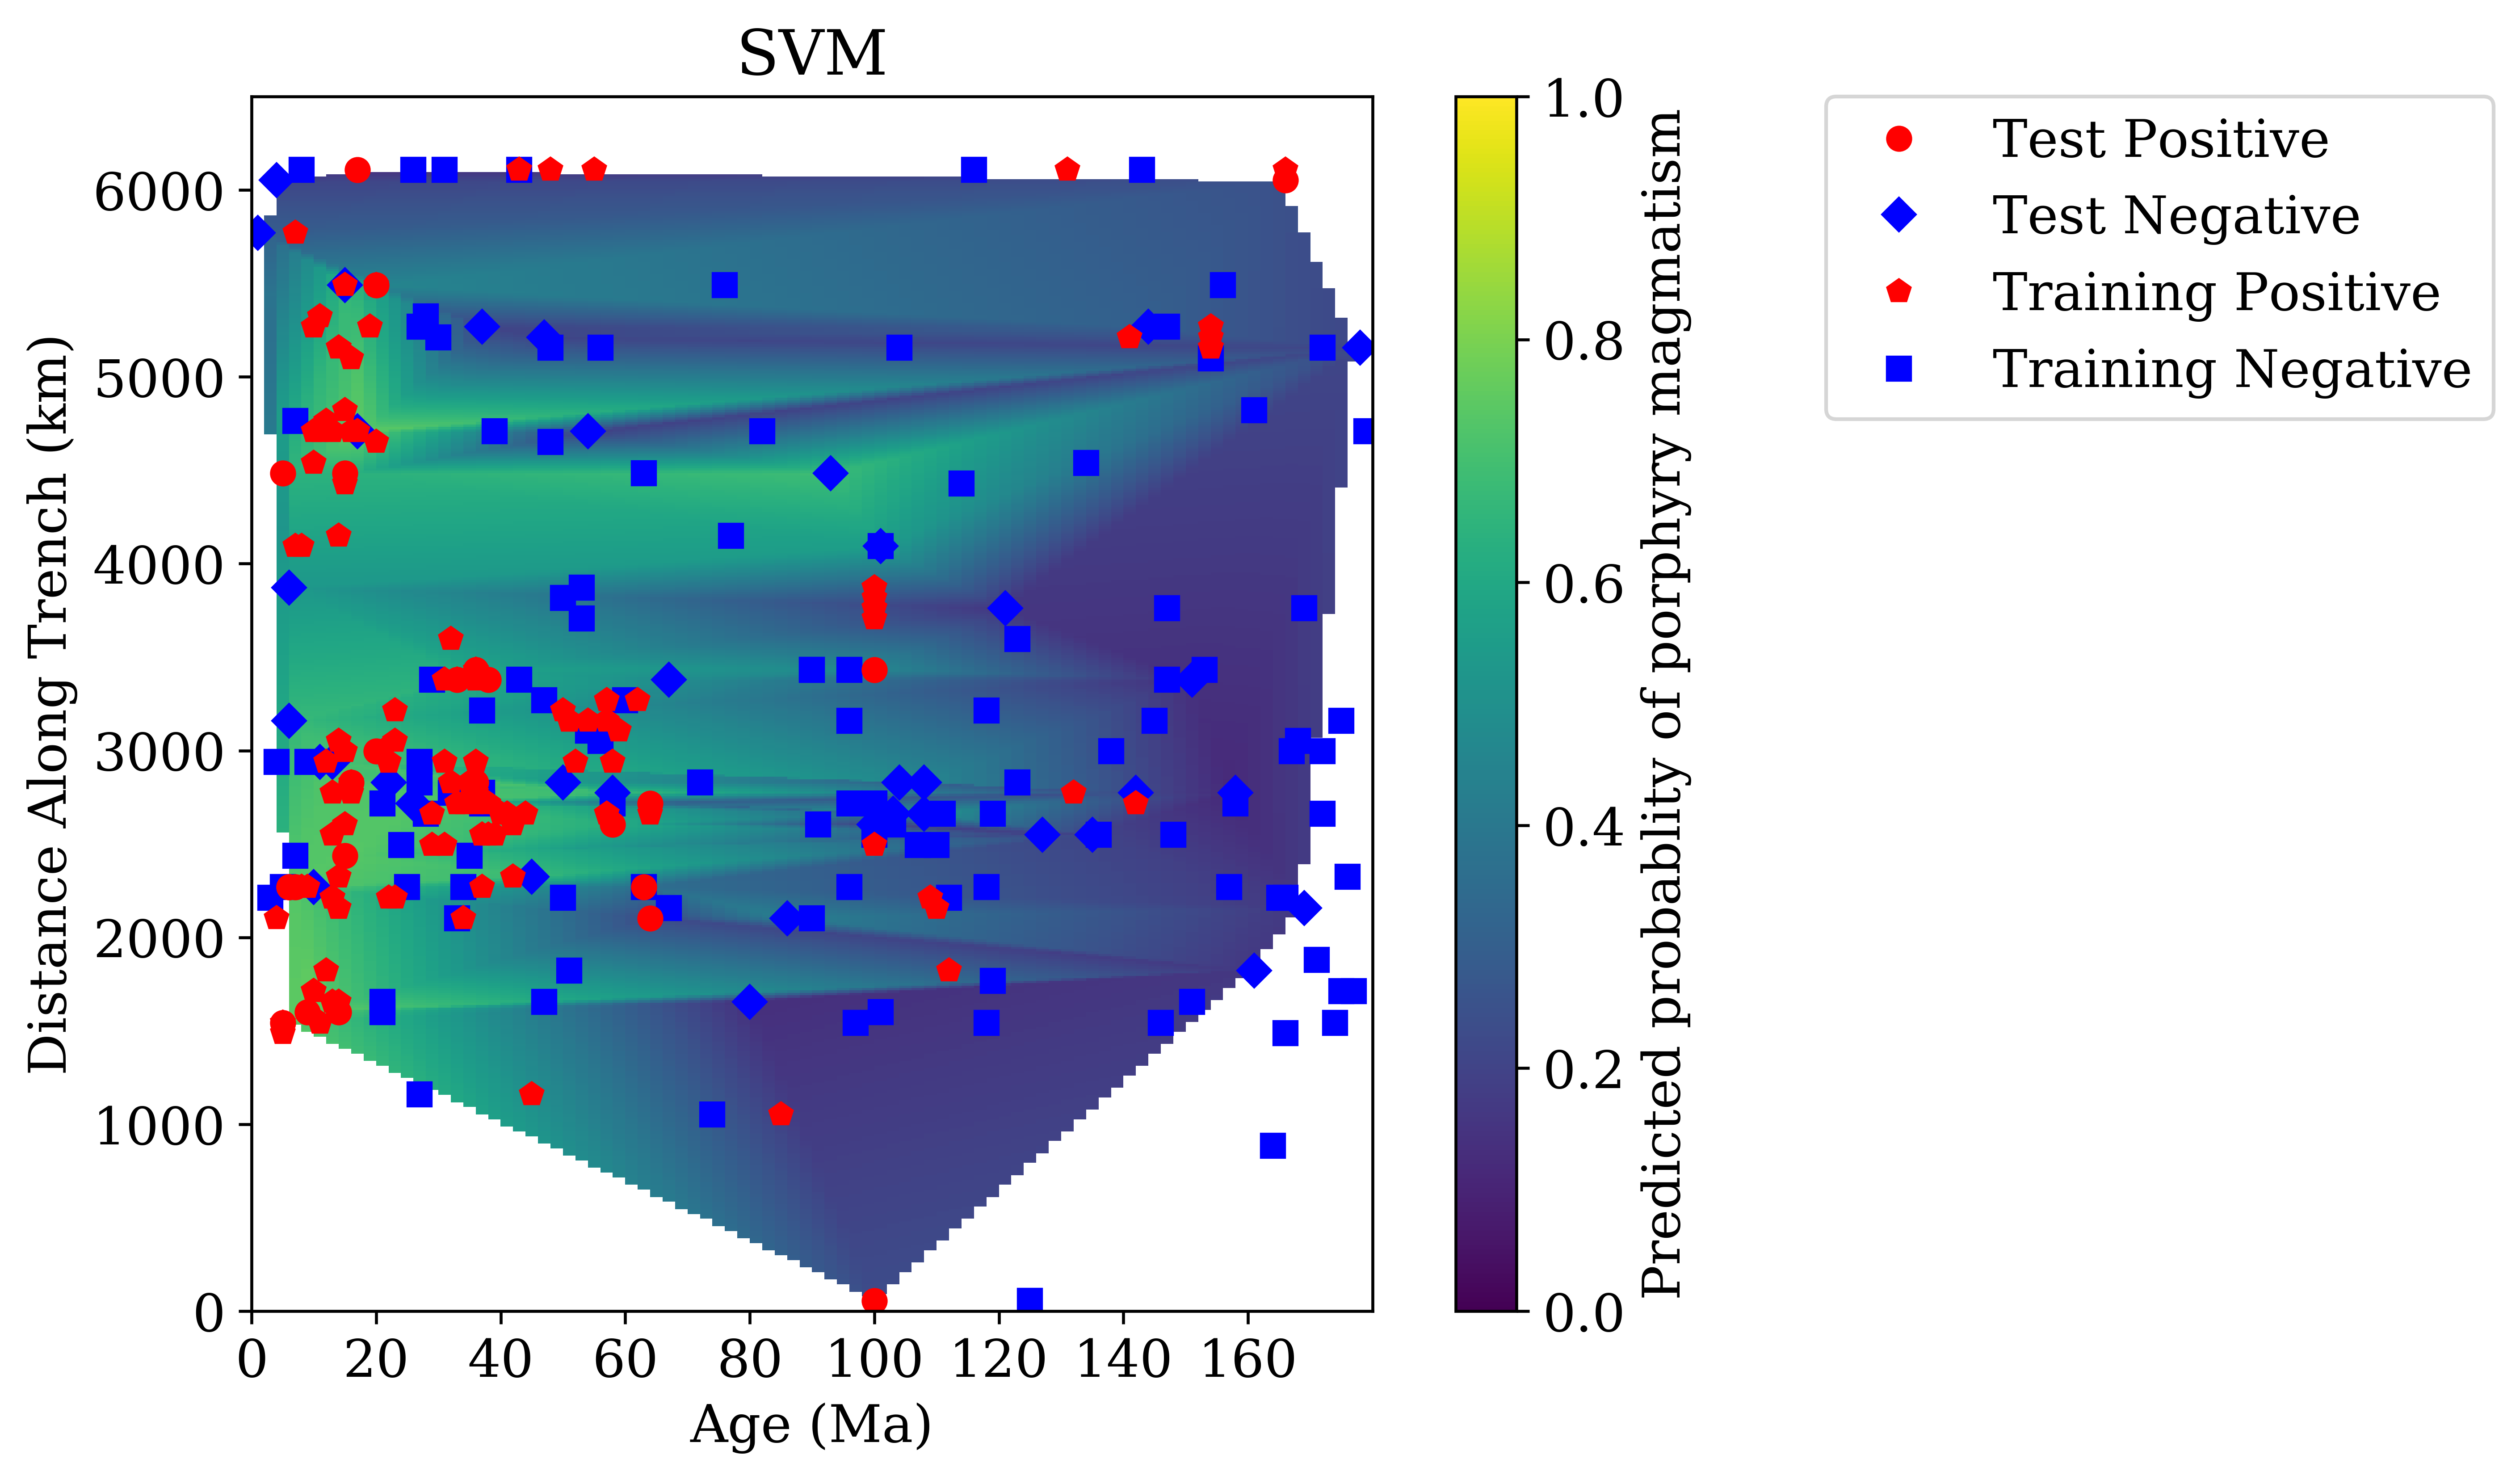

Five-fold cross validation scores:  [ 0.78688525  0.68852459  0.58333333  0.6         0.69491525]
SCORE Mean: 0.67 STD: 0.07


In [15]:
#Make some plots of typical results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,500))
#Retrieve the ML scores
values = p[:,1].flatten()
print("Number of points with an ML score: ", np.shape(values))

grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print("Shape of grid:", np.shape(grid_z1))

fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')

#Plot each of the result vectors
#negative testing
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#negative training
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#positive training
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')

#positive testing
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')

plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)



#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('SVM')

plt.show()

print("Five-fold cross validation scores: ", scores)
print('SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores))

#Random Forest Classification
Try a Random Forest classification also

In [16]:
print('Running...')
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)

print('Fitting...')
rf.fit(andesTrain[:,0:-3], andesTrain[0:,-1])


#predicted_probs = [[index + 1, x[1]] for index, x in enumerate(rf.predict_proba(testingSet))]

print('Score of test data: ', rf.score(andesTest[:,0:-3], andesTest[:,-1]))
p=numpy.array(rf.predict_proba(andesTest[:,0:-3]))
#q=numpy.array(predicted_probs)

#Get a cross-fold validation score using all subsets of the data
scores = cross_validation.cross_val_score(rf, andesData[:,0:-3], andesData[:,-1], cv=5)

print(rf.feature_importances_)
print(scores)

Running...
Fitting...
Score of test data:  0.72131147541
[ 0.28153678  0.24355048  0.22462338  0.25028936]
[ 0.70491803  0.6557377   0.63333333  0.58333333  0.6440678 ]


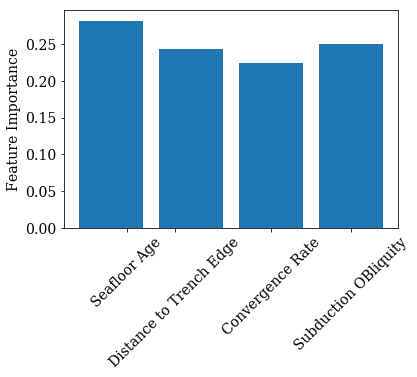

Feature Importance:  [ 0.28153678  0.24355048  0.22462338  0.25028936]


In [17]:
#Plot of feature importance
# paramLabels=["Seafloor Age","Distance to Trench Edge","Subducting Plate Normal", "Subducting Plate Parallel",\
#              "Overriding Plate Normal", "Overriding Plate Parallel",\
#              "Convergence Rate","Convergence Parallel",\
#              "Subduction Polarity", "Subduction OBliquity"]
        
paramLabels=["Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction OBliquity"]

fig, ax = plt.subplots()

# rects=ax.bar([0,1,2,3,4,5,6,7,8,9,10],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8,9],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4],rf.feature_importances_)
rects=ax.bar([0,1,2,3],rf.feature_importances_)

#print len(rf.feature_importances_)

#Set the location of the tick marks
# ax.set_xticks([-0.8,-0.8,0.2,1.2,2.2,3.4,4.8,5.4,6.6,7.4])
ax.set_xticks([0.2,0.8,2.0,3.0])

# plt.ylim([0,0.15])

#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(paramLabels,rotation=45)
ax.set_ylabel('Feature Importance')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.show()

print("Feature Importance: ", rf.feature_importances_)

Number of points with an ML score:  (61,)
Shape of grid: (500, 100)


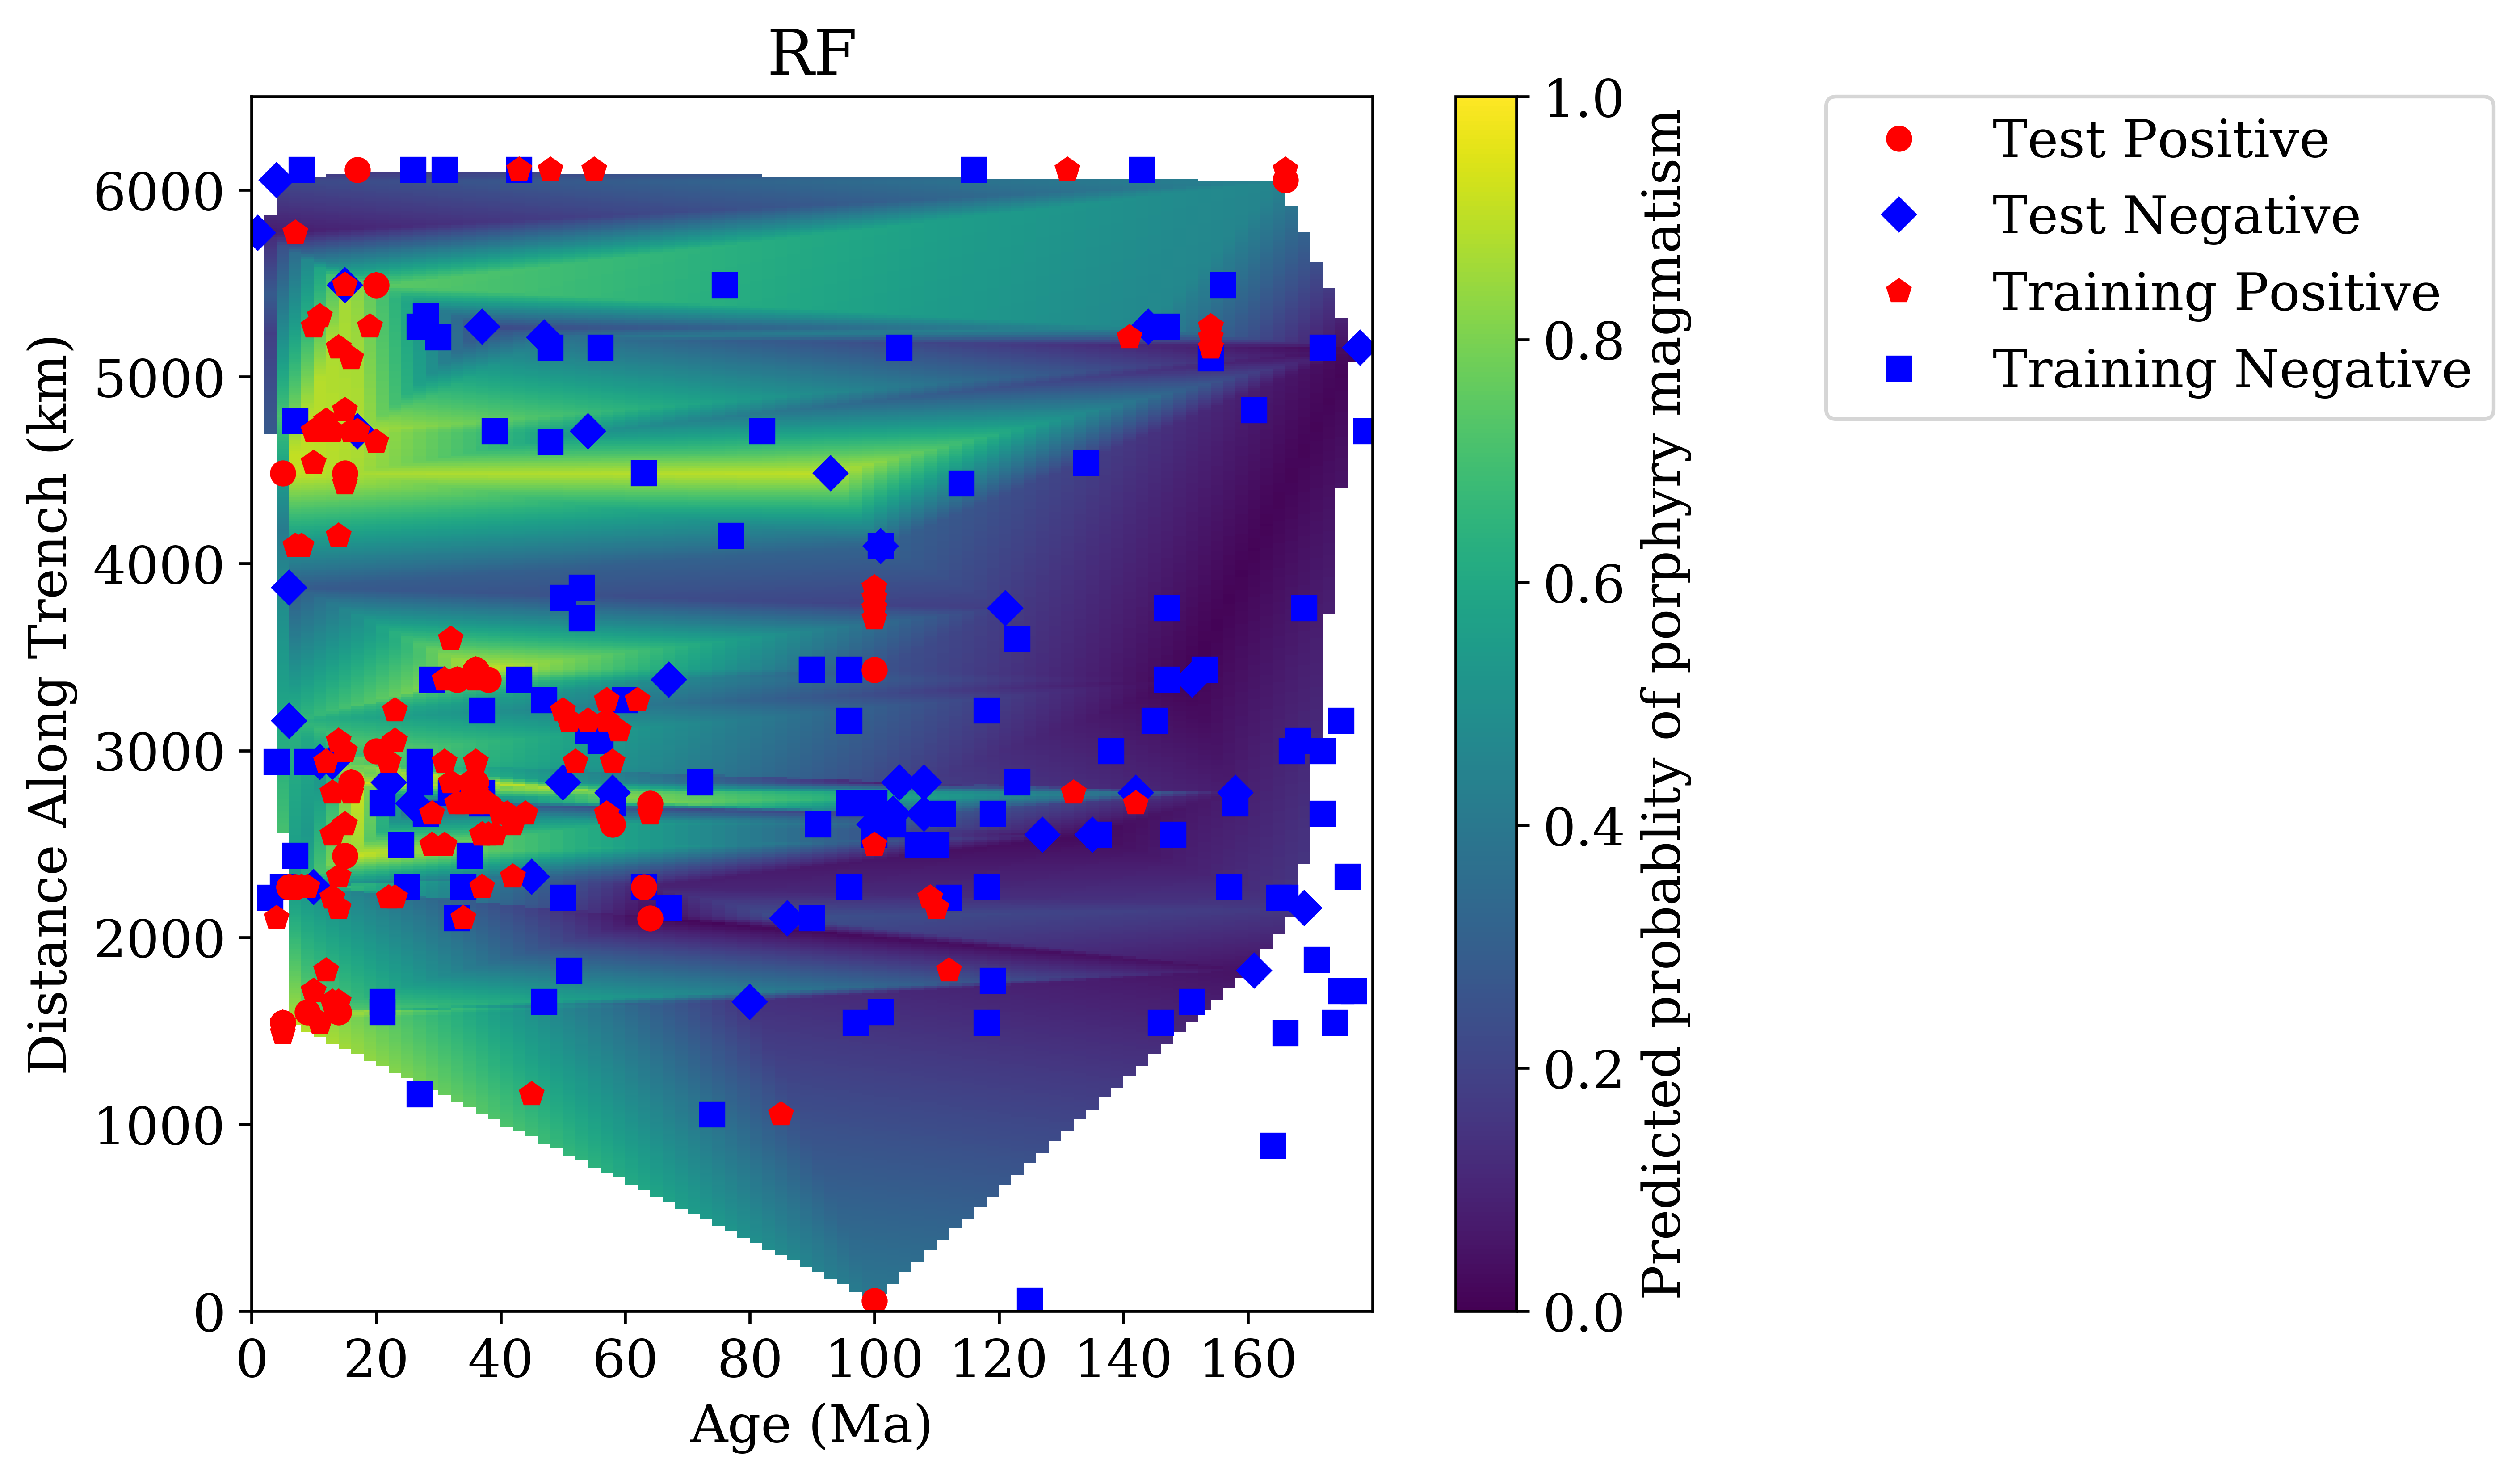

Five-fold cross validation scores:  [ 0.70491803  0.6557377   0.63333333  0.58333333  0.6440678 ]
SCORE Mean: 0.64 STD: 0.04


In [18]:
#Make some plots of the results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,500))
#Retrieve the ML scores
values = p[:,1].flatten()
print("Number of points with an ML score: ", np.shape(values))
grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print("Shape of grid:", np.shape(grid_z1))

fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')

#Plot each of the result vectors
#negative testing
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#negative training
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#positive training
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')

#positive testing
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')

plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)



#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('RF')

plt.show()

print("Five-fold cross validation scores: ", scores)
print('SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores))

In [20]:
# Random Accuracy = (No. Positive Examples)^2 + (No. Negative Examples)^2

#points = 0.50 (0.63=0.13, SVM 0.55=0.05)
#part = 0.68 (0.77=0.09, SVM 0.70=0.02)
#part time restric = 0.51 (RF 0.59=0.08, SVM 0.60=0.09)
#points time restric = 0.54 (RF 0.59=0.05, SVM 0.57=0.03)

#Pick only positive or only negative
print(176./221) #part 45/176/221
print(154./301) #points 147/154/301
print(45./77) #part time rest 32/45/77
print(121./188) #points time rest 121/67/188

0.7963800904977375
0.5116279069767442
0.5844155844155844
0.6436170212765957
